In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import math
torch.manual_seed(8)
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP.AttentiveLayers_Sim_copy import Fingerprint, GRN, AFSE
from AttentiveFP import Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer
from AttentiveFP.utils import EarlyStopping, eval
from AttentiveFP.utils import Meter
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import AttentiveFP.Featurizer
import scipy

In [3]:
train_filename = "./data/Ki_P14416_1_train.csv"
test_filename = "./data/Ki_P14416_1_test.csv"
train_rate = 1
val_rate = 0.2
random_seed = 68
batch_size = 10
file_list1 = train_filename.split('/')
file1 = file_list1[-1]
file1 = file1[:-10]
run_number = '_run_0'
model_file = "model_file/G_AFSE_"+file1+run_number
log_dir = f'log/{"G_AFSE_"+file1}'+run_number
print(file1)
print(model_file)

Ki_P14416_1
model_file/G_AFSE_Ki_P14416_1_run_0


In [4]:
# task_name = 'Malaria Bioactivity'
tasks = ['value']

# train_filename = "../data/active_inactive/median_active/EC50/Q99500.csv"
feature_filename = train_filename.replace('.csv','.pickle')
filename = train_filename.replace('.csv','')
prefix_filename = train_filename.split('/')[-1].replace('.csv','')
train_df = pd.read_csv(train_filename, header=0, names = ["smiles","value"],usecols=[1,2])
# train_df = train_df[1:]
# train_df = train_df.drop(0,axis=1,inplace=False) 
print(train_df[:5])
# print(train_df.iloc(1))
def add_canonical_smiles(train_df):
    smilesList = train_df.smiles.values
    print("number of all smiles: ",len(smilesList))
    atom_num_dist = []
    remained_smiles = []
    canonical_smiles_list = []
    for smiles in smilesList:
        try:        
            mol = Chem.MolFromSmiles(smiles)
            atom_num_dist.append(len(mol.GetAtoms()))
            remained_smiles.append(smiles)
            canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
        except:
            print(smiles)
            pass
    print("number of successfully processed smiles: ", len(remained_smiles))
    train_df = train_df[train_df["smiles"].isin(remained_smiles)]
    train_df['cano_smiles'] =canonical_smiles_list
    return train_df
# print(train_df)
train_df = add_canonical_smiles(train_df)

print(train_df.head())
# plt.figure(figsize=(5, 3))
# sns.set(font_scale=1.5)
# ax = sns.distplot(atom_num_dist, bins=28, kde=False)
# plt.tight_layout()
# # plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
# plt.show()
# plt.close()


                                              smiles     value
0  CC1CCN(C2=C1C=CC=C2CCN3CCN(CC3)C4=NSC5=CC=CC=C... -1.230449
1        C1CCCN(CC1)CCN2CCN(C2=O)C3=CC(=CC(=C3)Cl)Cl  0.199971
2  C1CN(CCN1CCCOC2=CC3=C(CNC3=O)C=C2)C4=CC=CC5=C4... -1.444045
3  CC1=C(OC=N1)C2=NN=C(N2C)SCCCN3CC4CC4(C3)C5=C(C... -2.677981
4  C1CN(CCN1CC2=CN=CC(=C2)C3=CC=CC=C3)C4=CC5=C(C=... -1.100371
number of all smiles:  6440
number of successfully processed smiles:  6440
                                              smiles     value  \
0  CC1CCN(C2=C1C=CC=C2CCN3CCN(CC3)C4=NSC5=CC=CC=C... -1.230449   
1        C1CCCN(CC1)CCN2CCN(C2=O)C3=CC(=CC(=C3)Cl)Cl  0.199971   
2  C1CN(CCN1CCCOC2=CC3=C(CNC3=O)C=C2)C4=CC=CC5=C4... -1.444045   
3  CC1=C(OC=N1)C2=NN=C(N2C)SCCCN3CC4CC4(C3)C5=C(C... -2.677981   
4  C1CN(CCN1CC2=CN=CC(=C2)C3=CC=CC=C3)C4=CC5=C(C=... -1.100371   

                                         cano_smiles  
0  CC(=O)N1CCC(C)c2cccc(CCN3CCN(c4nsc5ccccc45)CC3...  
1             O=C1N(CCN2CCCCCC2)CCN1c1cc

In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

p_dropout= 0.03
fingerprint_dim = 100

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
test_df = pd.read_csv(test_filename,header=0,names=["smiles","value","matched_smiles","matched_cano_smiles","matched_value"],usecols=[1,2,4,5,6])
test_df = add_canonical_smiles(test_df)
for l in test_df["cano_smiles"]:
    if l in train_df["cano_smiles"]:
        print("same smiles:",l)
        
print(test_df.shape)
print(test_df.head())

number of all smiles:  177
number of successfully processed smiles:  177
(177, 6)
                                              smiles     value  \
0                      CCCN1CCOC2C1CSC3=C2C=C(C=C3)O -0.049218   
1                      CCCN1CCOC2C1CCC3=C2C=C(C=C3)O -0.800029   
2              CCCN1CCC2=CC=CC3=C2C1CC4=C3C(=CC=C4)N -2.546543   
3  CC1=CC(=CC=C1)N2CCN(CC2)CCCCNC(=O)C3=CC4=CC=CC... -2.456366   
4          CCN(C)CCC1=C(NC2=CC=CC=C21)C3=CC=C(C=C3)F -1.230449   

                                      matched_smiles  \
0                      CCCN1CCOC2C1COC3=C2C=C(C=C3)O   
1                      CCCN1CCOC2C1COC3=C2C=C(C=C3)O   
2              CCCN1CCC2=CC=CC3=C2C1CC4=C3C(=CC=C4)O   
3  CC1=NC(=CC=C1)N2CCN(CC2)CCCCNC(=O)C3=CC4=CC=CC...   
4         CCN(C)CCC1=C(NC2=CC=CC=C21)C3=CC=C(C=C3)Cl   

                             matched_cano_smiles  matched_value  \
0                     CCCN1CCOC2c3cc(O)ccc3OCC21      -2.786041   
1                     CCCN1CCOC2c3cc(O)ccc3OCC21  

In [7]:
print(feature_filename)
print(filename)
total_df = pd.concat([train_df,test_df],axis=0)
total_smilesList = total_df['smiles'].values
print(len(total_smilesList))
# if os.path.isfile(feature_filename):
#     feature_dicts = pickle.load(open(feature_filename, "rb" ))
# else:
#     feature_dicts = save_smiles_dicts(smilesList,filename)
feature_dicts = save_smiles_dicts(total_smilesList,filename)
remained_df = total_df[total_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = total_df.drop(remained_df.index)

./data/Ki_P14416_1_train.pickle
./data/Ki_P14416_1_train
6617
feature dicts file saved as ./data/Ki_P14416_1_train.pickle


In [8]:
# train_df = train_df[:train_active]
val_df = train_df.sample(frac=val_rate,random_state=random_seed)
train_df = train_df.drop(val_df.index)
train_df = train_df.reset_index(drop=True)
train_df = train_df[train_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
train_df = train_df.reset_index(drop=True)
val_df = val_df[val_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
val_df = val_df.reset_index(drop=True)
test_df = test_df[test_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
test_df = test_df.reset_index(drop=True)
print(train_df.shape,val_df.shape,test_df.shape)

(5152, 3) (1288, 3) (177, 6)


In [9]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([total_df["cano_smiles"].values[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
amodel = AFSE(fingerprint_dim, output_units_num, p_dropout)
gmodel = GRN(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, p_dropout)
model.cuda()
amodel.cuda()
gmodel.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

optimizer_AFSE = optim.Adam(params=amodel.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

# optimizer_AFSE = optim.SGD(params=amodel.parameters(), lr = 0.01, momentum=0.9)

optimizer_GRN = optim.Adam(params=gmodel.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
# print(params)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)
        

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def sorted_show_pik(dataset, p, k, k_predict, i, acc):
    p_value = dataset[tasks[0]].astype(float).tolist()
    x = np.arange(0,len(dataset),1)
#     print('plt',dataset.head(),p[:10],k_predict,k)
#     plt.figure()
#     fig, ax1 = plt.subplots()
#     ax1.grid(False)
#     ax2 = ax1.twinx()
#     plt.grid(False)
    plt.scatter(x,p,marker='.',s=6,color='r',label='predict')
#     plt.ylabel('predict')
    plt.scatter(x,p_value,s=6,marker=',',color='blue',label='p_value')
    plt.axvline(x=k-1,ls="-",c="black")#添加垂直直线
    k_value = np.ones(len(dataset))
# #     print(EC50[k-1])
    k_value = k_value*k_predict
    plt.plot(x,k_value,'-',color='black')
    plt.ylabel('p_value')
    plt.title("epoch: {},  top-k recall: {}".format(i,acc))
    plt.legend(loc=3,fontsize=5)
    plt.show()
    

def topk_acc2(df, predict, k, active_num, show_flag=False, i=0):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
    
    df3 = df2[:k]  #取按预测值排完序后的前k个
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    k_true = true_sort[tasks[0]].values[k-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('k_true: ',type(k_true),k_true)
#     print('k_true: ',k_true,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=k_true,'acc_num: ',len(df3[df3['predict'].values>=k_true]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k)
    acc = len(df3[df3[tasks[0]].values>=k_true])/k #预测值前k个中真实排在前k个的个数/k
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/k
    if k>active_num:
        min_active = true_sort[tasks[0]].values[active_num-1]
        acc = len(df3[df3[tasks[0]].values>=min_active])/k
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

def topk_recall(df, predict, k, active_num, show_flag=False, i=0):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
        
    df3 = df2[:k]  #取按预测值排完序后的前k个，因为后面的全是-4.1
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    min_active = true_sort[tasks[0]].values[active_num-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('min_active: ',type(min_active),min_active)
#     print('min_active: ',min_active,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=min_active,'acc_num: ',len(df3[df3['predict'].values>=min_active]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k,'active_num: ',active_num)
    acc = len(df3[df3[tasks[0]].values>-4.1])/active_num #预测值前k个中真实排在前active_num个的个数/active_num
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/active_num
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

    
def topk_acc_recall(df, predict, k, active_num, show_flag=False, i=0):
    if k>active_num:
        return topk_recall(df, predict, k, active_num, show_flag, i)
    return topk_acc2(df,predict,k, active_num,show_flag,i)

def weighted_top_index(df, predict, active_num):
    weighted_acc_list=[]
    for k in np.arange(1,len(df)+1,1):
        acc, fp = topk_acc_recall(df, predict, k, active_num)
        weight = (len(df)-k)/len(df)
#         print('weight=',weight,'acc=',acc)
        weighted_acc_list.append(acc*weight)#
    weighted_acc_list = np.array(weighted_acc_list)
#     print('weighted_acc_list=',weighted_acc_list)
    return np.sum(weighted_acc_list)/weighted_acc_list.shape[0]

def AP(df, predict, active_num):
    prec = []
    rec = []
    for k in np.arange(1,len(df)+1,1):
        prec_k, fp1 = topk_acc2(df,predict,k, active_num)
        rec_k, fp2 = topk_recall(df, predict, k, active_num)
        prec.append(prec_k)
        rec.append(rec_k)
    # 取所有不同的recall对应的点处的精度值做平均
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # 计算包络线，从后往前取最大保证precise非减
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # 找出所有检测结果中recall不同的点
    i = np.where(mrec[1:] != mrec[:-1])[0]
#     print(prec)
#     print('prec='+str(prec)+'\n\n'+'rec='+str(rec))

    # and sum (\Delta recall) * prec
    # 用recall的间隔对精度作加权平均
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [11]:
def caculate_r2(y,predict):
#     print(y)
#     print(predict)
    y = torch.FloatTensor(y).reshape(-1,1)
    predict = torch.FloatTensor(predict).reshape(-1,1)
    y_mean = torch.mean(y)
    predict_mean = torch.mean(predict)
    
    y1 = torch.pow(torch.mm((y-y_mean).t(),(predict-predict_mean)),2)
    y2 = torch.mm((y-y_mean).t(),(y-y_mean))*torch.mm((predict-predict_mean).t(),(predict-predict_mean))
#     print(y1,y2)
    return y1/y2

In [12]:
from torch.autograd import Variable
def l2_norm(input, dim):
    norm = torch.norm(input, dim=dim, keepdim=True)
    output = torch.div(input, norm+1e-6)
    return output

def normalize_perturbation(d,dim=-1):
    output = l2_norm(d, dim)
    return output

def tanh(x):
    return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def perturb_feature(f, model, alpha=1, lamda=10**-learning_rate, output_lr=False, output_plr=False, y=None):
    mol_prediction = model(feature=f, d=0)
    pred = mol_prediction.detach()
#     f = torch.div(f, torch.norm(f, dim=-1, keepdim=True)+1e-9)
    eps = 1e-6 * normalize_perturbation(torch.randn(f.shape))
    eps = Variable(eps, requires_grad=True)
    # Predict on randomly perturbed image
    eps_p = model(feature=f, d=eps.cuda())
    eps_p_ = model(feature=f, d=-eps.cuda())
    p_aux = nn.Sigmoid()(eps_p/(pred+1e-6))
    p_aux_ = nn.Sigmoid()(eps_p_/(pred+1e-6))
#     loss = nn.BCELoss()(abs(p_aux),torch.ones_like(p_aux))+nn.BCELoss()(abs(p_aux_),torch.ones_like(p_aux_))
    loss = loss_function(p_aux,torch.ones_like(p_aux))+loss_function(p_aux_,torch.ones_like(p_aux_))
    loss.backward(retain_graph=True)

    # Based on perturbed image, get direction of greatest error
    eps_adv = eps.grad#/10**-learning_rate
    optimizer_AFSE.zero_grad()
    # Use that direction as adversarial perturbation
    eps_adv_normed = normalize_perturbation(eps_adv)
    d_adv = lamda * eps_adv_normed.cuda()
    if output_lr:
        f_p, max_lr = model(feature=f, d=d_adv, output_lr=output_lr)
    f_p = model(feature=f, d=d_adv)
    f_p_ = model(feature=f, d=-d_adv)
    p = nn.Sigmoid()(f_p/(pred+1e-6))
    p_ = nn.Sigmoid()(f_p_/(pred+1e-6))
    vat_loss = loss_function(p,torch.ones_like(p))+loss_function(p_,torch.ones_like(p_))
    if output_lr:
        if output_plr:
            loss = loss_function(mol_prediction,y)
            loss.backward(retain_graph=True)
            optimizer_AFSE.zero_grad()
            punish_lr = torch.norm(torch.mean(eps.grad,0))
            return eps_adv, d_adv, vat_loss, mol_prediction, max_lr, punish_lr
        return eps_adv, d_adv, vat_loss, mol_prediction, max_lr
    return eps_adv, d_adv, vat_loss, mol_prediction

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

def d_loss(f, pred, model, y_val):
    diff_loss = 0
    length = len(pred)
    for i in range(length):
        for j in range(length):
            if j == i:
                continue
            pred_diff = model(feature_only=True, feature1=f[i], feature2=f[j])
            true_diff = y_val[i] - y_val[j]
            diff_loss += loss_function(pred_diff, torch.Tensor([true_diff]).view(-1,1))
    diff_loss = diff_loss/(length*(length-1))
    return diff_loss

In [30]:
def CE(x,y):
    c = 0
    l = len(y)
    for i in range(l):
        if y[i]==1:
            c += 1
    w1 = (l-c)/l
    w0 = c/l
    loss = -w1*y*torch.log(x+1e-6)-w0*(1-y)*torch.log(1-x+1e-6)
    loss = loss.mean(-1)
    return loss

def weighted_CE_loss(x,y):
    weight = 1/(y.detach().float().mean(0)+1e-9)
    weighted_CE = nn.CrossEntropyLoss(weight=weight)
#     atom_weights = (atom_weights-min(atom_weights))/(max(atom_weights)-min(atom_weights))
    return weighted_CE(x, torch.argmax(y,-1))

# def generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list):
#     [a,b,c] = x_atom.shape
#     [d,e,f,g] = bond_neighbor.shape
#     ce_loss = nn.CrossEntropyLoss()
#     one_hot_loss = 0
#     interger_loss = 0
#     binary_loss = 0
#     counter_i = 0
#     counter_j = 0
#     validity_mask = torch.from_numpy(validity_mask).cuda()
#     for i in range(a):
#         l = (x_atom[i].sum(-1)!=0).sum(-1)
#         one_hot_loss += weighted_CE_loss(refer_atom_list[i,:l,:16], x_atom[i,:l,:16]) - \
#                         ((validity_mask[i,:l]*torch.log(1-atom_list[i,:l,:16]+1e-9)).sum(-1)/(validity_mask[i,:l].sum(-1)+1e-9)).mean(-1).mean(-1)+\
#                          weighted_CE_loss(refer_atom_list[i,:l,16:22], x_atom[i,:l,16:22])+ \
#                          weighted_CE_loss(refer_atom_list[i,:l,24:30], x_atom[i,:l,24:30])+ \
#                          weighted_CE_loss(refer_atom_list[i,:l,31:36], x_atom[i,:l,31:36])
#         interger_loss += loss_function(refer_atom_list[i,:l,23], x_atom[i,:l,23])+ \
#                         loss_function(refer_atom_list[i,:l,24], x_atom[i,:l,24])
#         binary_loss += CE(refer_atom_list[i,:l,30], x_atom[i,:l,30])+ \
#                         CE(refer_atom_list[i,:l,36], x_atom[i,:l,36])+ \
#                         CE(refer_atom_list[i,:l,37], x_atom[i,:l,37])+ \
#                         CE(refer_atom_list[i,:l,38], x_atom[i,:l,38])
#         counter_i += 1
#         for j in range(l):
#             n = (bond_neighbor[i,j].sum(-1)!=0).sum(-1)
#             if n==0:
#                 continue
#             one_hot_loss += weighted_CE_loss(refer_bond_list[i,j,:n,:4], bond_neighbor[i,j,:n,:4])+ \
#                              weighted_CE_loss(refer_bond_list[i,j,:n,6:], bond_neighbor[i,j,:n,6:])
#             binary_loss += CE(refer_bond_list[i,j,:n,4], bond_neighbor[i,j,:n,4])+ \
#                            CE(refer_bond_list[i,j,:n,5], bond_neighbor[i,j,:n,5])
#             counter_j += 1
#     one_hot_loss = one_hot_loss/(5*counter_i+2*counter_j)
#     interger_loss = interger_loss/(2*counter_i)
#     binary_loss = binary_loss/(4*counter_i+2*counter_j)
#     total_loss = (one_hot_loss + interger_loss + binary_loss)/3
#     return total_loss, one_hot_loss, interger_loss, binary_loss


def generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list):
    [a,b,c] = x_atom.shape
    [d,e,f,g] = bond_neighbor.shape
    ce_loss = nn.CrossEntropyLoss()
    one_hot_loss = 0
    run_times = 0
    validity_mask = torch.from_numpy(validity_mask).cuda()
    for i in range(a):
        l = (x_atom[i].sum(-1)!=0).sum(-1)
        atom_weights = 1/x_atom[i,:l,:16].mean(-2)
        ce_atom_loss = nn.CrossEntropyLoss(weight=atom_weights)
        one_hot_loss += ce_atom_loss(refer_atom_list[i,:l,:16], torch.argmax(x_atom[i,:l,:16],-1))- \
                         ((validity_mask[i,:l]*torch.log(1-atom_list[i,:l,:16]+1e-9)).sum(-1)/(validity_mask[i,:l].sum(-1)+1e-9)).mean(-1).mean(-1)
        run_times += 2
    total_loss = one_hot_loss/run_times
    return total_loss, 0, 0, 0


def train(model, amodel, gmodel, dataset, test_df, optimizer_list, loss_function, epoch):
    model.train()
    amodel.train()
    gmodel.train()
    optimizer, optimizer_AFSE, optimizer_GRN = optimizer_list
    np.random.seed(epoch)
    max_len = np.max([len(dataset),len(test_df)])
    valList = np.arange(0,max_len)
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, max_len, batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch%len(dataset),:]
        batch_test = test_df.loc[batch%len(test_df),:]
        global_step = epoch * len(batch_list) + counter
        smiles_list = batch_df.cano_smiles.values
        smiles_list_test = batch_test.cano_smiles.values
        y_val = batch_df[tasks[0]].values.astype(float)
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        x_atom_test, x_bonds_test, x_atom_index_test, x_bond_index_test, x_mask_test, smiles_to_rdkit_list_test = get_smiles_array(smiles_list_test,feature_dicts)
        activated_features, mol_feature = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),
                                                torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_activated_features=True)
#         mol_feature = torch.div(mol_feature, torch.norm(mol_feature, dim=-1, keepdim=True)+1e-9)
#         activated_features = torch.div(activated_features, torch.norm(activated_features, dim=-1, keepdim=True)+1e-9)
        refer_atom_list, refer_bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),
                                                  torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),
                                                  mol_feature=mol_feature,activated_features=activated_features)
        
        x_atom = torch.Tensor(x_atom)
        x_bonds = torch.Tensor(x_bonds)
        x_bond_index = torch.cuda.LongTensor(x_bond_index)
        
        bond_neighbor = [x_bonds[i][x_bond_index[i]] for i in range(len(batch_df))]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        
        eps_adv, d_adv, vat_loss, mol_prediction, conv_lr, punish_lr = perturb_feature(mol_feature, amodel, alpha=1, 
                                                                                       lamda=10**-learning_rate, output_lr=True, 
                                                                                       output_plr=True, y=torch.Tensor(y_val).view(-1,1)) # 10**-learning_rate     
        regression_loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))
        atom_list, bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),
                                      torch.Tensor(x_mask),mol_feature=mol_feature+d_adv/1e-6,activated_features=activated_features)
        success_smiles_batch, init_smiles, modified_smiles, success_batch, total_batch, reconstruction, validity, validity_mask = modify_atoms(smiles_list, x_atom, 
                            bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list,
                                                     refer_atom_list, refer_bond_list,topn=1, global_step=global_step)
        reconstruction_loss, one_hot_loss, interger_loss,binary_loss = generate_loss_function(refer_atom_list, x_atom, refer_bond_list, 
                                                                                              bond_neighbor, validity_mask, atom_list, 
                                                                                              bond_list)
#         x_atom_test = torch.Tensor(x_atom_test)
#         x_bonds_test = torch.Tensor(x_bonds_test)
#         x_bond_index_test = torch.cuda.LongTensor(x_bond_index_test)
        
#         bond_neighbor_test = [x_bonds_test[i][x_bond_index_test[i]] for i in range(len(batch_test))]
#         bond_neighbor_test = torch.stack(bond_neighbor_test, dim=0)
#         activated_features_test, mol_feature_test = model(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),
#                                                           torch.cuda.LongTensor(x_atom_index_test),torch.cuda.LongTensor(x_bond_index_test),
#                                                           torch.Tensor(x_mask_test),output_activated_features=True)
#         mol_feature_test = torch.div(mol_feature_test, torch.norm(mol_feature_test, dim=-1, keepdim=True)+1e-9)
#         activated_features_test = torch.div(activated_features_test, torch.norm(activated_features_test, dim=-1, keepdim=True)+1e-9)
#         eps_test, d_test, test_vat_loss, mol_prediction_test = perturb_feature(mol_feature_test, amodel, 
#                                                                                     alpha=1, lamda=10**-learning_rate)
#         atom_list_test, bond_list_test = gmodel(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),torch.cuda.LongTensor(x_atom_index_test),
#                                                 torch.cuda.LongTensor(x_bond_index_test),torch.Tensor(x_mask_test),
#                                                 mol_feature=mol_feature_test+d_test/1e-6,activated_features=activated_features_test.detach())
#         refer_atom_list_test, refer_bond_list_test = gmodel(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),
#                                                             torch.cuda.LongTensor(x_atom_index_test),torch.cuda.LongTensor(x_bond_index_test),torch.Tensor(x_mask_test),
#                                                             mol_feature=mol_feature_test,activated_features=activated_features_test.detach())
#         success_smiles_batch_test, modified_smiles_test, success_batch_test, total_batch_test, reconstruction_test, validity_test, validity_mask_test = modify_atoms(smiles_list_test, x_atom_test, 
#                             bond_neighbor_test, atom_list_test, bond_list_test,smiles_list_test,smiles_to_rdkit_list_test,
#                                                      refer_atom_list_test, refer_bond_list_test,topn=1)
#         test_reconstruction_loss, test_one_hot_loss, test_interger_loss,test_binary_loss = generate_loss_function(atom_list_test, x_atom_test, bond_list_test, bond_neighbor_test, validity_mask_test, atom_list_test, bond_list_test)
        
        if vat_loss>1:
            vat_loss = 1*(vat_loss/(vat_loss+1e-6).item())    
#         if vat_loss>1 or test_vat_loss>1:
#             vat_loss = 1*(vat_loss/(vat_loss+1e-6).item())
#             test_vat_loss = 1*(test_vat_loss/(test_vat_loss+1e-6).item())
        
        max_lr = 1e-3
        conv_lr = conv_lr - conv_lr**2 + 0.1*punish_lr
        if conv_lr < max_lr and conv_lr >= 0:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = conv_lr.detach()
                AFSE_lr = conv_lr 
        if conv_lr < 0:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = 0
                AFSE_lr = 0
        else:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = max_lr
                AFSE_lr = max_lr
        
        logger.add_scalar('loss/regression', regression_loss, global_step)
        logger.add_scalar('loss/AFSE', vat_loss, global_step)
#         logger.add_scalar('loss/AFSE_test', test_vat_loss, global_step)
        logger.add_scalar('loss/GRN', reconstruction_loss, global_step)
#         logger.add_scalar('loss/GRN_test', test_reconstruction_loss, global_step)
        logger.add_scalar('loss/GRN_one_hot', one_hot_loss, global_step)
        logger.add_scalar('loss/GRN_interger', interger_loss, global_step)
        logger.add_scalar('loss/GRN_binary', binary_loss, global_step)
        logger.add_scalar('lr/max_lr', conv_lr, global_step)
        logger.add_scalar('lr/punish_lr', punish_lr, global_step)
        logger.add_scalar('lr/AFSE_lr', AFSE_lr, global_step)
    
        optimizer.zero_grad()
        optimizer_AFSE.zero_grad()
        optimizer_GRN.zero_grad()
        loss =  regression_loss + vat_loss + reconstruction_loss
        loss.backward()
        optimizer.step()
        optimizer_AFSE.step()
        optimizer_GRN.step()
        
def clear_atom_map(mol):
    [a.ClearProp('molAtomMapNumber') for a  in mol.GetAtoms()]
    return mol

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

def modify_atoms(smiles, x_atom, bond_neighbor, atom_list, bond_list, y_smiles, smiles_to_rdkit_list,refer_atom_list, 
                 refer_bond_list,topn=1, print_flag=False, global_step=0):
    x_atom = x_atom.cpu().detach().numpy()
    bond_neighbor = bond_neighbor.cpu().detach().numpy()
    atom_list = atom_list.cpu().detach().numpy()
    bond_list = bond_list.cpu().detach().numpy()
    refer_atom_list = refer_atom_list.cpu().detach().numpy()
    refer_bond_list = refer_bond_list.cpu().detach().numpy()
    atom_symbol_sorted = np.argsort(x_atom[:,:,:16], axis=-1)
    atom_symbol_generated_sorted = np.argsort(atom_list[:,:,:16], axis=-1)
    generate_confidence_sorted = np.sort(atom_list[:,:,:16], axis=-1)
    init_smiles = []
    modified_smiles = []
    success_smiles = []
    success_reconstruction = 0
    success_validity = 0
    recon_rate = 0
    total_atom = 0
    success = [0 for i in range(topn)]
    total = [0 for i in range(topn)]
    confidence_threshold = 0.001
    validity_mask = np.zeros_like(atom_list[:,:,:16])
    symbol_list = ['B','C','N','O','F','Si','P','S','Cl','As','Se','Br','Te','I','At','other']
    symbol_to_rdkit = [4,6,7,8,9,14,15,16,17,33,34,35,52,53,85,0]
    for i in range(len(atom_list)):
        rank = 0
        top_idx = 0
        flag = 0
        first_run_flag = True
        l = (x_atom[i].sum(-1)!=0).sum(-1)
        cano_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles[i]))
        mol = mol_with_atom_index(Chem.MolFromSmiles(smiles[i]))
        counter = 0
        for j in range(l): 
            if mol.GetAtomWithIdx(int(smiles_to_rdkit_list[cano_smiles][j])).GetAtomicNum() == \
                symbol_to_rdkit[refer_atom_list[i,j,:16].argmax(-1)]:
                counter += 1
            if print_flag:
                print(f'atom#{smiles_to_rdkit_list[cano_smiles][j]}(f):',{symbol_list[k]: np.around(refer_atom_list[i,j,k],3) for k in range(16)},
                      f'\natom#{smiles_to_rdkit_list[cano_smiles][j]}(f+d):',{symbol_list[k]: np.around(atom_list[i,j,k],3) for k in range(16)},
                     '\n------------------------------------------------------------------------------------------------------------')
#         print('预测为每个原子的平均概率：\n',np.around(atom_list[i,:l,:16].mean(1),2))
#         print('预测为每个原子的最大概率：\n',np.around(atom_list[i,:l,:16].max(1),2))
        recon_rate += counter
        total_atom += l
        if counter == l:
            success_reconstruction += 1
        while not flag==topn:
            if rank == 16:
                rank = 0
                top_idx += 1
            if top_idx == l:
                if print_flag:
                    print('没有满足条件的分子生成。')
                flag += 1
                continue
#             if np.sum((atom_symbol_sorted[i,:l,-1]!=atom_symbol_generated_sorted[i,:l,-1-rank]).astype(int))==0:
#                 print(f'根据预测的第{rank}大概率的原子构成的分子与原分子一致，原子位重置为0，生成下一个元素……')
#                 rank += 1
#                 top_idx = 0
#                 generate_index = np.argsort((atom_list[i,:l,:16]-refer_atom_list[i,:l,:16] -\
#                                              x_atom[i,:l,:16]).max(-1))[-1-top_idx]
            if print_flag:
                print('i:',i,'top_idx:', top_idx, 'rank:',rank)
            if rank == 0:
                generate_index = np.argsort((atom_list[i,:l,:16]-10*refer_atom_list[i,:l,:16] -\
                                             x_atom[i,:l,:16]).max(-1))[-1-top_idx]
            atom_symbol_generated = np.argsort(atom_list[i,generate_index,:16]-\
                                                    10*refer_atom_list[i,generate_index,:16] -\
                                                    x_atom[i,generate_index,:16])[-1-rank]
            if atom_symbol_generated==x_atom[i,generate_index,:16].argmax(-1):
                if print_flag:
                    print('生成了相同元素，生成下一个元素……')
                rank += 1
                continue
            generate_rdkit_index = smiles_to_rdkit_list[cano_smiles][generate_index]
            if np.sort(atom_list[i,generate_index,:16]-x_atom[i,generate_index,:16])[-1-rank]<confidence_threshold:
                if print_flag:
                    print(f'原子位{generate_rdkit_index}生成{symbol_list[atom_symbol_generated]}元素的置信度小于{confidence_threshold}，寻找下一个原子位……')
                top_idx += 1
                rank = 0
                continue
            if symbol_to_rdkit[atom_symbol_generated]==0:
                if print_flag:
                    print('生成了不推荐的other元素')
                rank += 1
                continue
            mol.GetAtomWithIdx(int(generate_rdkit_index)).SetAtomicNum(symbol_to_rdkit[atom_symbol_generated])
            print_mol = mol
            try:
                Chem.SanitizeMol(mol)
                if first_run_flag == True:
                    success_validity += 1
                total[flag] += 1
                if Chem.MolToSmiles(clear_atom_map(print_mol))==y_smiles[i]:
                    success[flag] +=1
                    if print_flag:
                        print('Congratulations!', success, total)
                    success_smiles.append(Chem.MolToSmiles(clear_atom_map(print_mol)))
                mol_init = mol_with_atom_index(Chem.MolFromSmiles(smiles[i]))
                init_smiles.append(smiles[i])
                modified_smiles.append(Chem.MolToSmiles(clear_atom_map(print_mol)))
                if print_flag:
                    print("修改前的分子：", smiles[i])
                    display(mol_init)
                    print(f"将第{generate_rdkit_index}个原子修改为{symbol_list[atom_symbol_generated]}的分子：", Chem.MolToSmiles(clear_atom_map(print_mol)))
                    display(mol_with_atom_index(mol))
                    mol_y = mol_with_atom_index(Chem.MolFromSmiles(y_smiles[i]))
                    print("高活性分子：", y_smiles[i])
                    display(mol_y)
                rank += 1
                flag += 1
            except:
                if print_flag:
                    print(f"第{generate_rdkit_index}个原子符号修改为{symbol_list[atom_symbol_generated]}不符合规范，生成下一个元素……")
                rank += 1
                validity_mask[i,generate_index,atom_symbol_generated] = 1
                first_run_flag = False
    recon_rate = recon_rate/total_atom
    if global_step > 0:
        logger.add_scalar('acc/recon_rate', recon_rate, global_step)
    return success_smiles, init_smiles, modified_smiles, success, total, success_reconstruction, success_validity, validity_mask
        
def eval(model, amodel, gmodel, dataset, topn=1, output_feature=False, generate=False, modify_atom=True,return_GRN_loss=False, 
         viz=False, print_flag=False, validate=False):
    model.eval()
    amodel.eval()
    gmodel.eval()
    predict_list = []
    test_MSE_list = []
    r2_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    feature_list = []
    d_list = []
    success = [0 for i in range(topn)]
    total = [0 for i in range(topn)]
    init_smiles_list = []
    generated_smiles = []
    success_smiles = []
    success_reconstruction = 0
    success_validity = 0
    reconstruction_loss, one_hot_loss, interger_loss, binary_loss = [0,0,0,0]
    
# #     取dataset中排序后的第k个
#     sorted_dataset = dataset.sort_values(by=tasks[0],ascending=False)
#     k_df = sorted_dataset.iloc[[k-1]]
#     k_smiles = k_df['cano_smiles'].values
#     k_value = k_df[tasks[0]].values.astype(float)    
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
#     print(batch_list)
    for counter, batch in enumerate(batch_list):
#         print(type(batch))
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        if generate and validate:
            matched_smiles_list = batch_df.matched_cano_smiles.values
        else:
            matched_smiles_list = smiles_list
#         print(batch_df)
        y_val = batch_df[tasks[0]].values.astype(float)
#         print(type(y_val))
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(matched_smiles_list,feature_dicts)
        x_atom = torch.Tensor(x_atom)
        x_bonds = torch.Tensor(x_bonds)
        x_bond_index = torch.cuda.LongTensor(x_bond_index)
        bond_neighbor = [x_bonds[i][x_bond_index[i]] for i in range(len(batch_df))]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        
        lamda=10**-learning_rate
        activated_features, mol_feature = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_activated_features=True)
#         mol_feature = torch.div(mol_feature, torch.norm(mol_feature, dim=-1, keepdim=True)+1e-9)
#         activated_features = torch.div(activated_features, torch.norm(activated_features, dim=-1, keepdim=True)+1e-9)
        eps_adv, d_adv, vat_loss, mol_prediction = perturb_feature(mol_feature, amodel, alpha=1, lamda=lamda)
#         print(mol_feature,d_adv)
        atom_list, bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),
                                      torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),
                                      torch.Tensor(x_mask),mol_feature=mol_feature+d_adv/(1e-6),activated_features=activated_features)
        refer_atom_list, refer_bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),mol_feature=mol_feature,activated_features=activated_features)
        if generate:
            if modify_atom:     
                success_smiles_batch, init_smiles, modified_smiles, success_batch, total_batch, reconstruction, validity, validity_mask = modify_atoms(matched_smiles_list, x_atom, 
                            bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list,
                                                     refer_atom_list, refer_bond_list,topn=topn, print_flag=print_flag)
            else:
                modified_smiles = modify_bonds(matched_smiles_list, x_atom, bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list)
            init_smiles_list.extend(init_smiles)
            generated_smiles.extend(modified_smiles)
            success_smiles.extend(success_smiles_batch)
            reconstruction_loss, one_hot_loss, interger_loss, binary_loss = generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list)
            for n in range(topn):
                success[n] += success_batch[n]
                total[n] += total_batch[n]
            if print_flag:
                print('congratulations:',success,total)
            success_reconstruction += reconstruction
            success_validity += validity
        d = d_adv.cpu().detach().numpy().tolist()
        d_list.extend(d)
        mol_feature_output = mol_feature.cpu().detach().numpy().tolist()
        feature_list.extend(mol_feature_output)
#         MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')   
#         print(type(mol_prediction))
        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         r2 = caculate_r2(mol_prediction, torch.Tensor(y_val).view(-1,1))
# #         r2_list.extend(r2.cpu().detach().numpy())
#         if r2!=r2:
#             r2 = torch.tensor(0)
#         r2_list.append(r2.item())
#         predict_list.extend(mol_prediction.cpu().detach().numpy())
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        predict_list.extend(mol_prediction.cpu().detach().numpy())
#         test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.view(-1,1).cpu().numpy())
#     print(r2_list)
    if generate:
        generated_num = len(generated_smiles)
        eval_num = len(dataset)
        unique = generated_num
        novelty = generated_num
        for i in range(generated_num):
            for j in range(generated_num-i-1):
                if generated_smiles[i]==generated_smiles[i+j+1]:
                    unique -= 1
            for k in range(eval_num):
                if generated_smiles[i]==dataset['smiles'].values[k]:
                    novelty -= 1
        unique_rate = unique/(generated_num+1e-9)
        novelty_rate = novelty/(generated_num+1e-9)
        if print_flag:
            print(f'successfully/total generated molecules =', {f'Top-{i+1}': f'{success[i]}/{total[i]}' for i in range(topn)})
        return success_reconstruction/len(dataset), success_validity/len(dataset), unique_rate, novelty_rate, success_smiles, init_smiles_list, generated_smiles, caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list
    if return_GRN_loss:
        return d_list, feature_list,caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list,reconstruction_loss, one_hot_loss, interger_loss,binary_loss
    if output_feature:
        return d_list, feature_list,caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list
    return caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list

epoch = 0
max_epoch = 1000
batch_size = 10
patience = 100
stopper = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_model.pth')
stopper_afse = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_amodel.pth')
stopper_generate = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_gmodel.pth')

In [14]:
import datetime
from tensorboardX import SummaryWriter
now = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
if os.path.isdir(log_dir):
    for files in os.listdir(log_dir):
        os.remove(log_dir+"/"+files)
    os.rmdir(log_dir)
logger = SummaryWriter(log_dir)
print(log_dir)

log/G_AFSE_Ki_P14416_1_run_0


In [15]:
optimizer_list = [optimizer, optimizer_AFSE, optimizer_GRN]
while epoch < max_epoch:
    train(model, amodel, gmodel, train_df, test_df, optimizer_list, loss_function, epoch)
#     print(train_df.shape,test_df.shape)
    train_recon, train_validity, train_unique, train_novelty, _, _, _, train_r2, train_MSE, train_predict = eval(model, amodel, gmodel, train_df, topn=1, generate=True)
    val_recon, val_validity, val_unique, val_novelty, _, _, _, val_r2, val_MSE, val_predict = eval(model, amodel, gmodel, val_df, topn=1, generate=True)
    
    test_recon, test_validity, test_unique, test_novelty, _, _, _, test_r2, test_MSE, test_predict = eval(model, amodel, gmodel, test_df, topn=1, generate=True)

    val_average = (val_recon+val_validity+val_unique+val_novelty)/4
    test_average = (test_recon+test_validity+test_unique+test_novelty)/4
    epoch = epoch + 1
    global_step = epoch * int(np.max([len(train_df),len(test_df)])/batch_size)
    early_stop = stopper.step(val_average, model)
    early_stop = stopper_afse.step(val_average, amodel, if_print=False)
    early_stop = stopper_generate.step(val_average, gmodel, if_print=False)
#     print('epoch {:d}/{:d}, validation {} {:.4f}, {} {:.4f},best validation {r2} {:.4f}'.format(epoch, total_epoch, 'r2', val_r2, 'mse:',val_MSE, stopper.best_score))
    print(epoch, 'Rec: %.4f'%train_recon,'%.4f'%val_recon,'%.4f'%test_recon, 'Vali: %.4f'%val_validity,'%.4f'%test_validity,
         'Uni: %.2f'%val_unique,'%.2f'%test_unique, 'Nov: %.2f'%val_novelty,'%.2f'%test_novelty,
         'Avg: %.4f'%val_average,'%.4f'%test_average)
    if early_stop:
        break


1 Rec: 0.0000 0.0000 0.0000 Vali: 0.9441 0.9492 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.7323 0.7373
2 Rec: 0.0499 0.0536 0.0621 Vali: 0.9682 0.9548 Uni: 0.98 1.00 Nov: 1.00 1.00 Avg: 0.7512 0.7542
3 Rec: 0.0557 0.0551 0.0621 Vali: 0.9705 0.9887 Uni: 0.98 1.00 Nov: 1.00 1.00 Avg: 0.7525 0.7627
4 Rec: 0.3946 0.3851 0.3559 Vali: 0.8416 0.8475 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8032 0.8008
5 Rec: 0.3952 0.3874 0.3559 Vali: 0.8758 0.8362 Uni: 0.99 0.99 Nov: 1.00 1.00 Avg: 0.8124 0.7965
EarlyStopping counter: 1 out of 100
6 Rec: 0.3956 0.3874 0.3559 Vali: 0.8571 0.8475 Uni: 0.98 1.00 Nov: 1.00 1.00 Avg: 0.8066 0.8008
EarlyStopping counter: 2 out of 100
7 Rec: 0.3956 0.3874 0.3559 Vali: 0.8750 0.8814 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8123 0.8093
8 Rec: 0.3956 0.3874 0.3559 Vali: 0.8797 0.8870 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8135 0.8107
9 Rec: 0.3956 0.3874 0.3559 Vali: 0.8804 0.8983 Uni: 0.99 0.99 Nov: 1.00 1.00 Avg: 0.8142 0.8120
10 Rec: 0.3956 0.3874 0.3559 Vali: 0.8890 0.8814 Uni: 0

EarlyStopping counter: 43 out of 100
67 Rec: 0.9854 0.9814 0.9944 Vali: 0.6778 0.6836 Uni: 0.99 0.99 Nov: 1.00 1.00 Avg: 0.9124 0.9176
EarlyStopping counter: 44 out of 100
68 Rec: 0.9854 0.9814 0.9944 Vali: 0.6506 0.5989 Uni: 0.99 0.98 Nov: 1.00 1.00 Avg: 0.9058 0.8941
EarlyStopping counter: 45 out of 100
69 Rec: 0.9854 0.9814 0.9944 Vali: 0.6467 0.6441 Uni: 0.99 0.98 Nov: 1.00 1.00 Avg: 0.9050 0.9056
EarlyStopping counter: 46 out of 100
70 Rec: 0.9854 0.9814 0.9944 Vali: 0.6312 0.6045 Uni: 0.99 0.98 Nov: 1.00 1.00 Avg: 0.9001 0.8936
EarlyStopping counter: 47 out of 100
71 Rec: 0.9854 0.9814 0.9944 Vali: 0.6258 0.6271 Uni: 0.99 0.98 Nov: 1.00 1.00 Avg: 0.8998 0.8994
EarlyStopping counter: 48 out of 100
72 Rec: 0.9854 0.9814 0.9944 Vali: 0.6615 0.6215 Uni: 0.99 0.98 Nov: 1.00 1.00 Avg: 0.9080 0.8980
EarlyStopping counter: 49 out of 100
73 Rec: 0.9854 0.9814 0.9944 Vali: 0.6460 0.6610 Uni: 0.99 0.99 Nov: 1.00 1.00 Avg: 0.9038 0.9119
74 Rec: 0.9854 0.9814 0.9944 Vali: 0.7158 0.7062 Uni: 0

EarlyStopping counter: 5 out of 100
130 Rec: 0.9854 0.9814 0.9944 Vali: 0.5761 0.5650 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8867 0.8898
EarlyStopping counter: 6 out of 100
131 Rec: 0.9854 0.9814 0.9944 Vali: 0.5342 0.5424 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8773 0.8842
EarlyStopping counter: 7 out of 100
132 Rec: 0.9854 0.9814 0.9944 Vali: 0.6498 0.5932 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.9053 0.8969
EarlyStopping counter: 8 out of 100
133 Rec: 0.9854 0.9814 0.9944 Vali: 0.4798 0.4576 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8627 0.8630
EarlyStopping counter: 9 out of 100
134 Rec: 0.9854 0.9814 0.9944 Vali: 0.4953 0.4915 Uni: 0.98 1.00 Nov: 1.00 1.00 Avg: 0.8645 0.8715
EarlyStopping counter: 10 out of 100
135 Rec: 0.9854 0.9814 0.9944 Vali: 0.5474 0.4802 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8792 0.8686
EarlyStopping counter: 11 out of 100
136 Rec: 0.9854 0.9814 0.9944 Vali: 0.6436 0.6328 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.9032 0.9068
EarlyStopping counter: 12 out of 100
137 Rec: 0.9854 

EarlyStopping counter: 67 out of 100
192 Rec: 0.9854 0.9814 0.9944 Vali: 0.4627 0.5085 Uni: 0.99 0.99 Nov: 1.00 1.00 Avg: 0.8587 0.8731
EarlyStopping counter: 68 out of 100
193 Rec: 0.9854 0.9814 0.9944 Vali: 0.5831 0.5141 Uni: 0.99 0.99 Nov: 1.00 1.00 Avg: 0.8889 0.8745
EarlyStopping counter: 69 out of 100
194 Rec: 0.9854 0.9814 0.9944 Vali: 0.5241 0.3842 Uni: 1.00 1.00 Nov: 1.00 1.00 Avg: 0.8753 0.8446
EarlyStopping counter: 70 out of 100
195 Rec: 0.9854 0.9814 0.9944 Vali: 0.5683 0.4915 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8858 0.8715
EarlyStopping counter: 71 out of 100
196 Rec: 0.9854 0.9814 0.9944 Vali: 0.5054 0.5141 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8698 0.8771
EarlyStopping counter: 72 out of 100
197 Rec: 0.9854 0.9814 0.9944 Vali: 0.5311 0.5424 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.8759 0.8842
EarlyStopping counter: 73 out of 100
198 Rec: 0.9854 0.9814 0.9944 Vali: 0.6933 0.5989 Uni: 0.99 1.00 Nov: 1.00 1.00 Avg: 0.9163 0.8983
EarlyStopping counter: 74 out of 100
199 Rec: 0.

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0.0

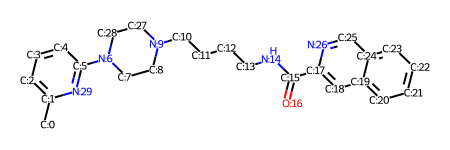

将第0个原子修改为N的分子： Nc1cccc(N2CCN(CCCCNC(=O)c3cc4ccccc4cn3)CC2)n1


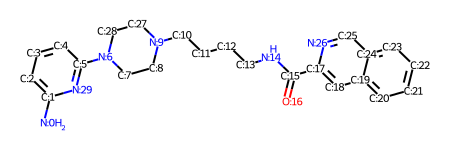

高活性分子： Cc1cccc(N2CCN(CCCCNC(=O)c3cc4ccccc4cn3)CC2)c1


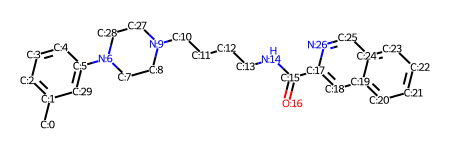

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, '

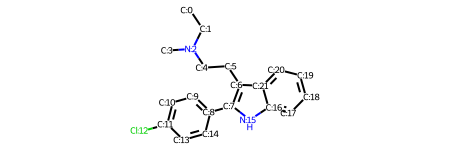

将第3个原子修改为F的分子： CCN(F)CCc1c(-c2ccc(Cl)cc2)[nH]c2ccccc12


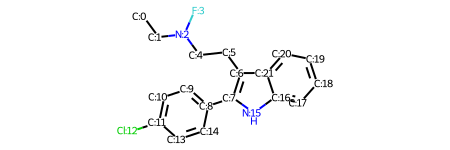

高活性分子： CCN(C)CCc1c(-c2ccc(F)cc2)[nH]c2ccccc12


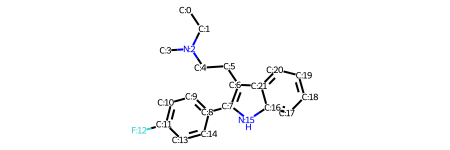

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, '

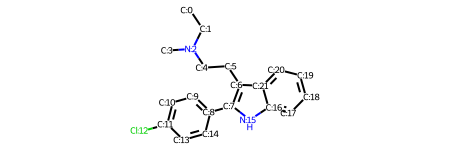

将第3个原子修改为F的分子： CCN(F)CCc1c(-c2ccc(Cl)cc2)[nH]c2ccccc12


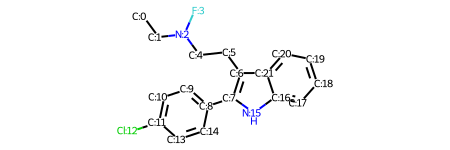

高活性分子： CCN(C)CCc1c(-c2ccc(C#N)cc2)[nH]c2ccccc12


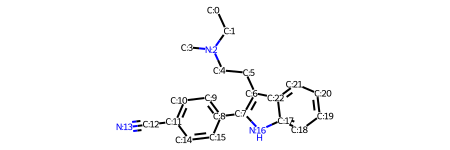

atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 1.0

原子位15生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
修改前的分子： Cc1c(-c2ccccc2)nnn1C1CCN(Cc2ccccc2)CC1


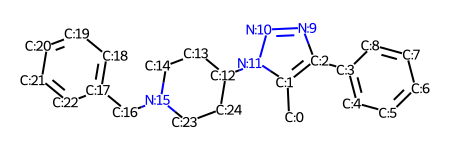

将第0个原子修改为F的分子： Fc1c(-c2ccccc2)nnn1C1CCN(Cc2ccccc2)CC1


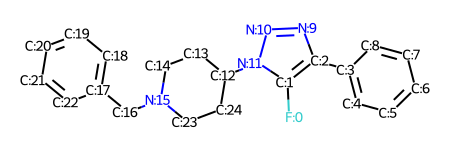

高活性分子： Cc1c(-c2ccccc2)cnn1C1CCN(Cc2ccccc2)CC1


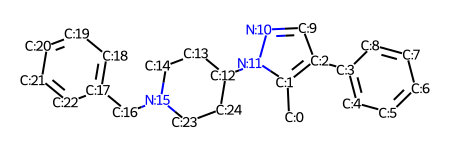

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#22(f): {'B': 0.0, 'C': 

原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 1 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 2 rank: 0
原子位12生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 3 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 4 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 5 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 6 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 7 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 8 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 9 rank: 0
原子位26生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 10 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 11 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 12 rank: 0
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 13 rank: 0
原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 14 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 15 rank: 0
原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 16 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 17 rank: 0
第14个原子符号修改为F不符合规范，生成下一个元素……

i: 8 top_idx: 15 rank: 0
第12个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 15 rank: 1
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
第17个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 16 rank: 1
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位1生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 18 rank: 0
第2个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 18 rank: 1
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 19 rank: 0
第20个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 19 rank: 1
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 20 rank: 0
第0个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 20 rank: 1
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
-

atom#1(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0

原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 1 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 2 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 3 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 4 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 5 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 6 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 7 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 8 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 9 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 10 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 11 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 12 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 13 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 14 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 15 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 16 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 17 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原

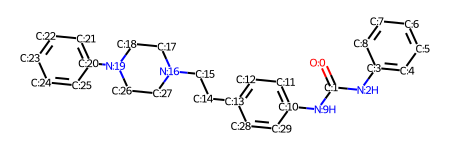

将第1个原子修改为At的分子： O=[AtH](Nc1ccccc1)Nc1ccc(CCN2CCN(c3ccccc3)CC2)cc1


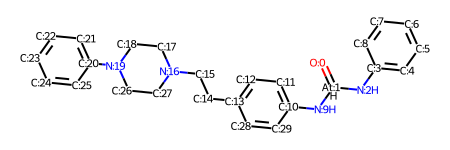

高活性分子： O=C(Nc1ccc(CCN2CCN(c3ccccc3)CC2)cc1)Nc1ccccn1


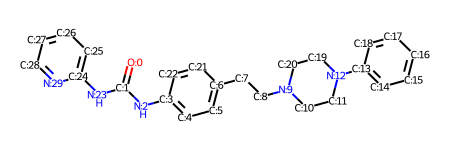

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.002, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#19(f): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#19(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 2 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 3 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 4 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 5 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 6 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 7 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 8 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 9 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 10 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 17 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 18 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子

原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 2 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 3 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 4 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 5 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 6 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 7 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 8 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 9 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 10 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 11 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 12 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 13 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 15 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 16 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 17 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 18 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原

i: 5 top_idx: 8 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 18 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 19 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 20 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 21 rank: 0
原子位20生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 22 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 23 rank: 0
原子位17生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 24 rank: 0
原子位27生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 25 rank

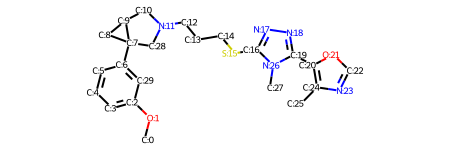

将第29个原子修改为N的分子： COc1cccc(C23CC2CN(CCCSc2nnc(-c4ocnc4C)n2C)C3)n1


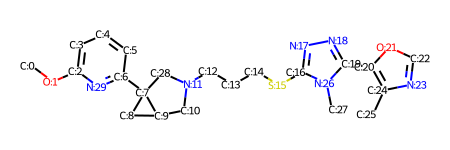

高活性分子： Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3cccc(F)c3)C2)n1C


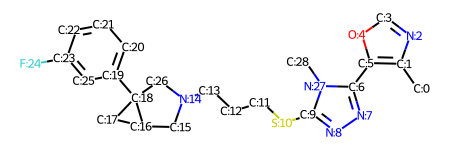

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.9

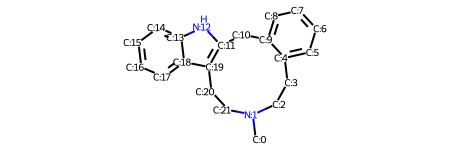

将第10个原子修改为N的分子： CN1CCC2CCCCC2NC2NC3CCCCC3N2CC1


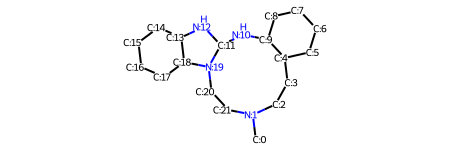

高活性分子： CN1CCc2ccccc2Cc2sc3ccccc3c2CC1


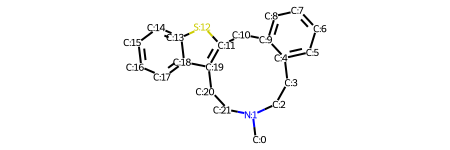

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#25(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#25(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0.0

原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 27 rank: 0
原子位33生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 28 rank: 0
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 29 rank: 0
原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 30 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 31 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 32 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 33 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
congratulations: [0] [7]
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.996, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, '

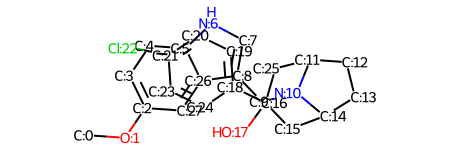

将第17个原子修改为C的分子： COc1ccc2[nH]cc(CN3C4CCC3CC(C)(c3ccc(Cl)cc3)C4)c2c1


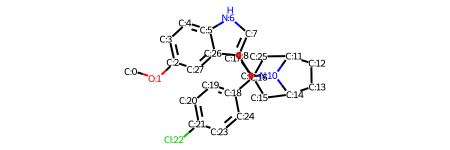

高活性分子： COc1ccc2occ(CN3C4CCC3CC(O)(c3ccc(Cl)cc3)C4)c2c1


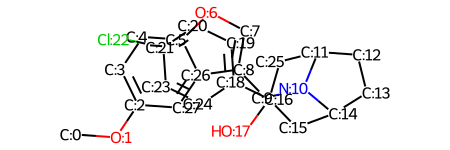

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#18(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#20(f): {'B': 0.0, 'C': 

修改前的分子： CCCN1CCc2cccc3c2C1Cc1ccc(C)c(O)c1-3


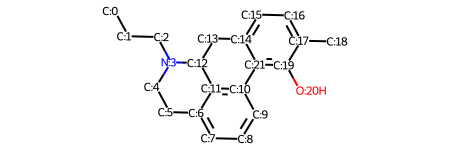

将第20个原子修改为Cl的分子： CCCN1CCc2cccc3c2C1Cc1ccc(C)c(Cl)c1-3


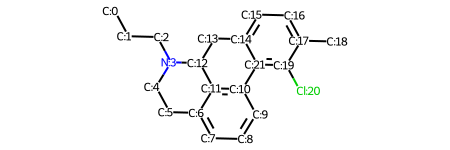

高活性分子： CCCN1CCc2cccc3c2C1Cc1ccc(O)c(O)c1-3


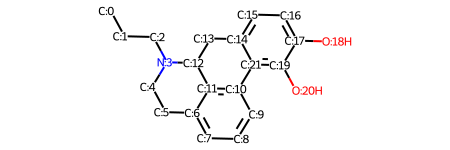

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#18(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#20(f): {'B': 0.0, 'C': 0.0, 'N': 0.

修改前的分子： CN1CCN(C2Cc3ccccc3Sc3ccc(CN)cc32)CC1


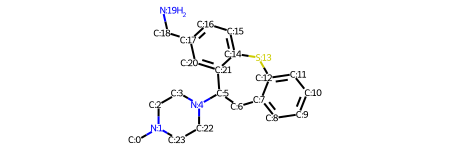

将第0个原子修改为S的分子： NCc1ccc2c(c1)C(N1CCN(S)CC1)Cc1ccccc1S2


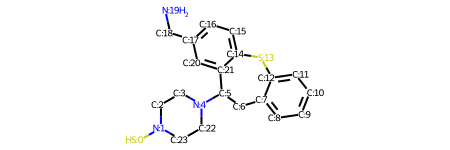

高活性分子： CN1CCN(C2Cc3ccccc3Sc3ccc(C#N)cc32)CC1


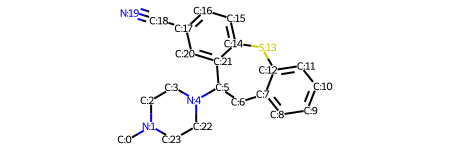

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.0, 'N': 0.999

原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 3 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 4 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 5 rank: 0
原子位2生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 6 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 7 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 8 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 9 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 10 rank: 0
原子位30生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 11 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 12 rank: 0
原子位25生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 13 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 15 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 16 rank: 0
第20个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 16 rank: 1
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 17 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 18 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位

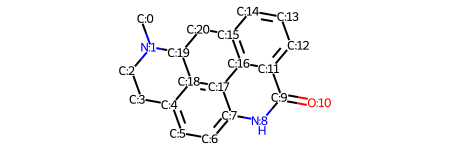

将第9个原子修改为S的分子： CN1CCc2ccc3c4c2C1Cc1cccc(c1-4)S(=O)N3


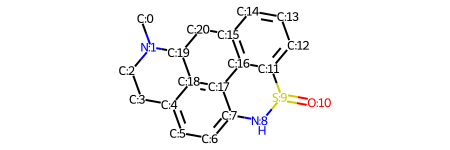

高活性分子： CN1CCc2ccc3oc(=O)c4cccc5c4c3c2C1C5


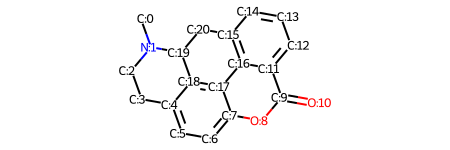

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.0, 'N':

原子位9生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 1 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 2 rank: 0
原子位3生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 3 rank: 0
原子位4生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 4 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 5 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位23生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位17生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位0生成N元素的置信度小于0.001，寻找下一个原子

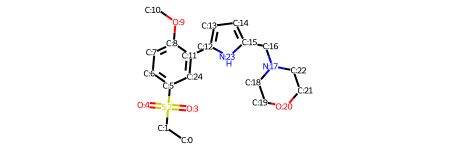

将第20个原子修改为N的分子： CCS(=O)(=O)c1ccc(OC)c(-c2ccc(CN3CCNCC3)[nH]2)c1


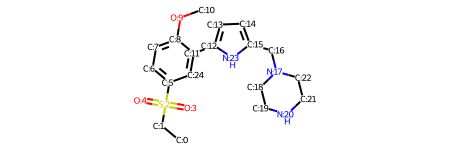

高活性分子： CCS(=O)(=O)c1ccc(OC)c(-c2ccc(CN3CCCCC3)[nH]2)c1


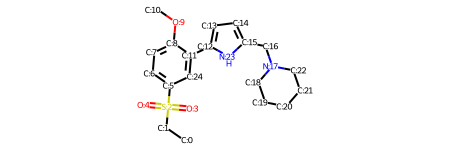

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#24(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#29(f): {'B': 0.0, 'C': 

原子位30生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 3 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 4 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 5 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 6 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 7 rank: 0
原子位32生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 8 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 9 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 10 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 11 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 12 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 13 rank: 0
原子位24生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 14 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 15 rank: 0
原子位34生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 16 rank: 0
原子位33生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 17 rank: 0
原子位28生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 18 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 19 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下

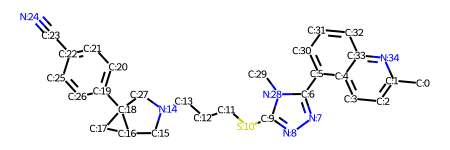

将第0个原子修改为N的分子： Cn1c(SCCCN2CC3CC3(c3ccc(C#N)cc3)C2)nnc1-c1cccc2nc(N)ccc12


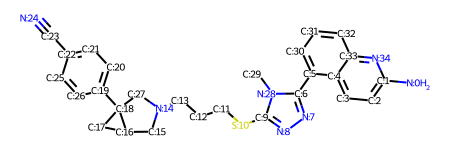

高活性分子： Cc1ccc2c(-c3nnc(SCCCN4CC5CC5(c5ccc(Cl)cc5)C4)n3C)cccc2n1


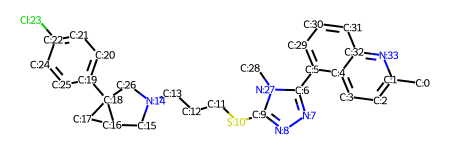

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.997, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C':

------------------------------------------------------------------------------------------------------------
i: 8 top_idx: 0 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 1 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
修改前的分子： OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2Cc1c[nH]c2ccccc12


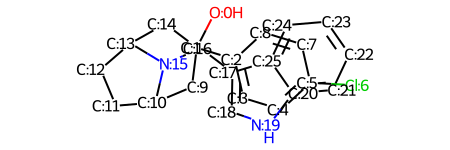

将第6个原子修改为O的分子： Oc1ccc(C2(O)CC3CCC(C2)N3Cc2c[nH]c3ccccc23)cc1


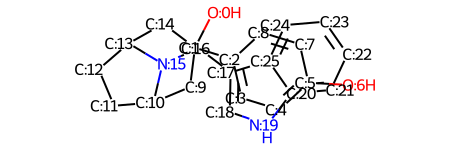

高活性分子： OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2Cc1csc2ccccc12


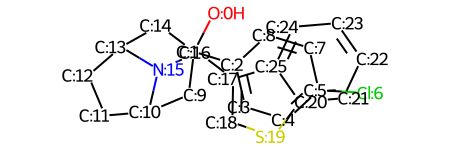

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.997, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C':

原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 1 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 2 rank: 0
修改前的分子： OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2Cc1csc2ccccc12


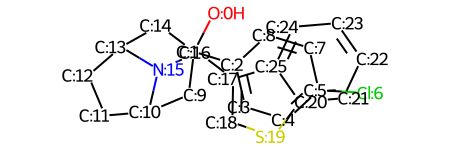

将第6个原子修改为O的分子： Oc1ccc(C2(O)CC3CCC(C2)N3Cc2csc3ccccc23)cc1


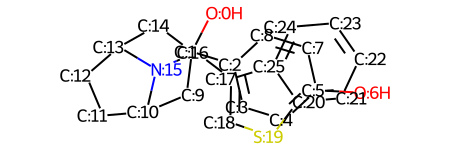

高活性分子： OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2Cc1coc2ccccc12


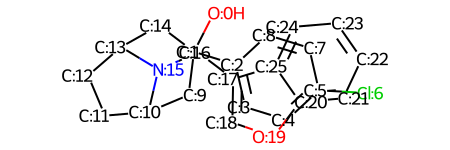

congratulations: [0] [15]
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B

原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 1 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 2 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 3 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 4 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 5 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 6 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 7 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 8 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 9 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 10 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 11 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 12 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 13 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 14 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 15 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 16 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 17 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原

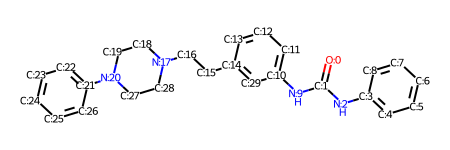

将第1个原子修改为At的分子： O=[AtH](Nc1ccccc1)Nc1cccc(CCN2CCN(c3ccccc3)CC2)c1


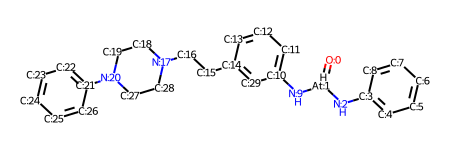

高活性分子： O=C(Nc1ccncc1)Nc1cccc(CCN2CCN(c3ccccc3)CC2)c1


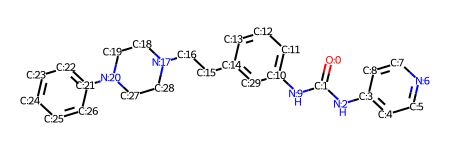

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.0, 'N

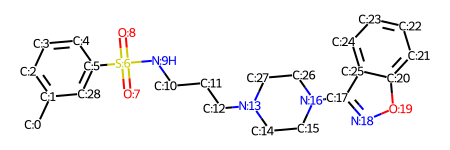

将第0个原子修改为N的分子： Nc1cccc(S(=O)(=O)NCCCN2CCN(c3noc4ccccc34)CC2)c1


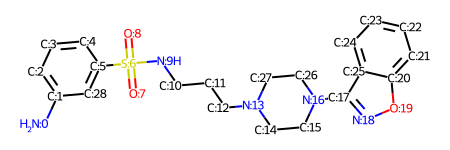

高活性分子： Cc1cccc(S(=O)(=O)NCCCN2CCN(c3nsc4ccccc34)CC2)c1


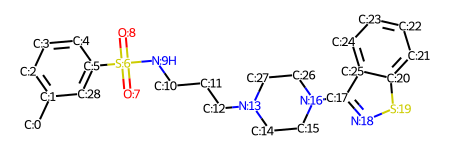

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#15(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#21(f): {'B': 0.0, 'C': 0.998, 'N'

第21个原子符号修改为N不符合规范，生成下一个元素……
i: 2 top_idx: 17 rank: 1
第21个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 17 rank: 2
原子位21生成At元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 18 rank: 0
第14个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 18 rank: 1
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 19 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 20 rank: 0
第9个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 20 rank: 1
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 21 rank: 0
第24个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 21 rank: 1
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 22 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 23 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 24 rank: 0
第12个原子符号修改为N不符合规范，生成下一个元素……
i: 2 top_idx: 24 rank: 1
原子位12生成Cl元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 

原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 6 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 7 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 8 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 9 rank: 0
第10个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 9 rank: 1
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 10 rank: 0
第7个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 10 rank: 1
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
原子位5生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位14生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 17 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 18 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 19 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 20 rank: 0
第1个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_id

生成了不推荐的other元素
i: 4 top_idx: 0 rank: 1
修改前的分子： O=C(NCC=CCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccncc1


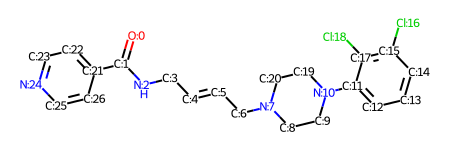

将第2个原子修改为C的分子： O=C(CCC=CCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccncc1


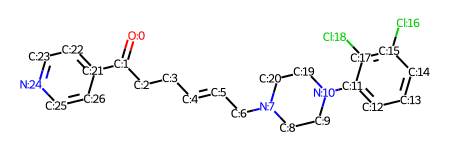

高活性分子： O=C(NCC=CCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccccc1


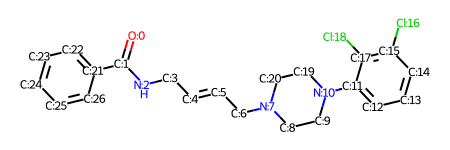

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C'

原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位1生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
第21个原子符号修改为F不符合规范，生成下一个元素……
i: 5 top_idx: 16 rank: 1
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 18 rank: 0
第4个原子符号修改为F不符合规范，生成下一个元素……
i: 5 top_idx: 18 rank: 1
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 19 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 20 rank: 0
原子位18生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 21 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 22 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'A

atom#32(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#32(f+d): {'B': 0.0, 'C': 0.995, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.

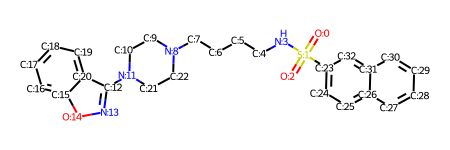

将第14个原子修改为S的分子： O=S(=O)(NCCCCN1CCN(C2NSC3CCCCC32)CC1)c1ccc2ccccc2c1


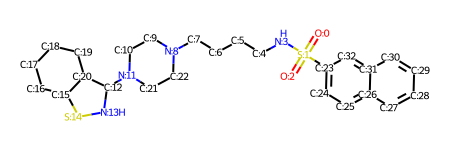

高活性分子： O=S(=O)(NCCCCN1CCN(c2nsc3ccccc23)CC1)c1ccc2ccccc2c1


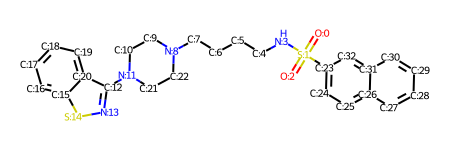

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0

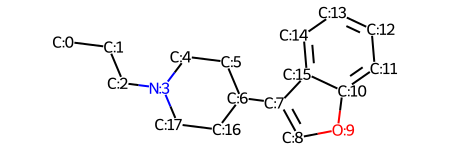

将第9个原子修改为S的分子： CCCN1CCC(c2csc3ccccc23)CC1


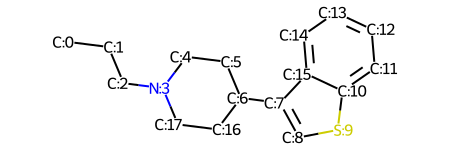

高活性分子： CCCN1CCC(c2csc3ccccc23)CC1


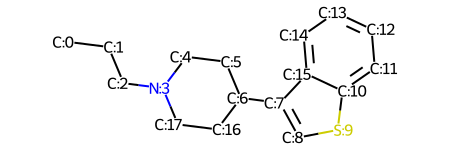

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#29(f): {'B': 0.0, 'C': 0.996,

原子位10生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位3生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 18 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一

原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 2 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 3 rank: 0
原子位20生成O元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 4 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 5 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 6 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 7 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 8 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 9 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 10 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 11 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 12 rank: 0
原子位25生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 13 rank: 0
原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 14 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 15 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 16 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 17 rank: 0
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 18 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原

------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------

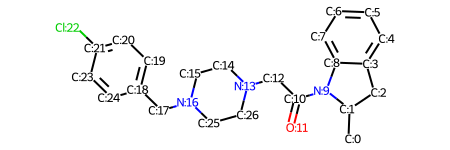

将第0个原子修改为N的分子： NC1Cc2ccccc2N1C(=O)CN1CCN(Cc2ccc(Cl)cc2)CC1


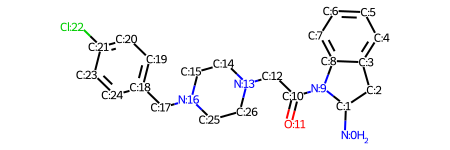

高活性分子： Cc1ccc(CN2CCC(CC(=O)N3c4ccccc4CC3C)CC2)cc1


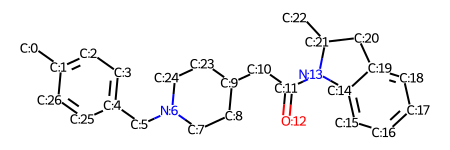

atom#0(f): {'B': 0.0, 'C': 0.994, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.994, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#22(f): {'B': 0.0, '

原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 1 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 2 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 3 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 4 rank: 0
原子位22生成O元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 5 rank: 0
原子位11生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 6 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 7 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 8 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 9 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 10 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 11 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 12 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 13 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 14 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 15 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 16 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 17 rank: 0
原子位16生成C元素的置信度小于0.001，寻找下一个原子位

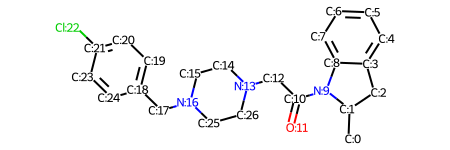

将第0个原子修改为N的分子： NC1Cc2ccccc2N1C(=O)CN1CCN(Cc2ccc(Cl)cc2)CC1


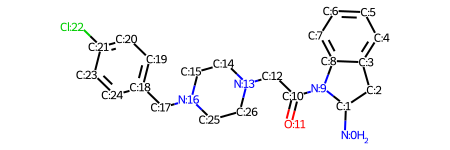

高活性分子： CC1Cc2ccccc2N1C(=O)CC1CCN(Cc2ccc(Cl)cc2)CC1


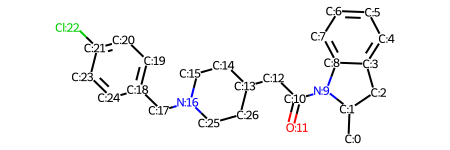

atom#0(f): {'B': 0.0, 'C': 0.994, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.994, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#22(f): {'B': 0.0, '

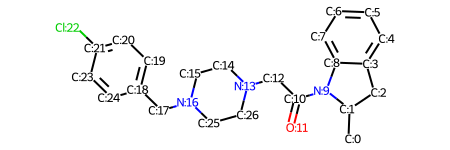

将第0个原子修改为N的分子： NC1Cc2ccccc2N1C(=O)CN1CCN(Cc2ccc(Cl)cc2)CC1


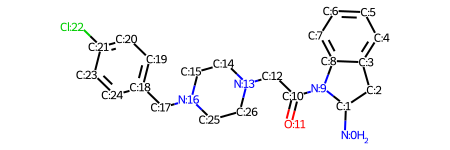

高活性分子： CC1Cc2ccccc2N1C(=O)CN1CCN(Cc2ccc(F)cc2)CC1


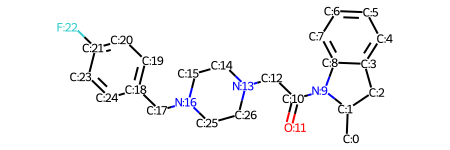

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0

原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位6生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 17 rank: 0
第12个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 17 rank: 1
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 18 rank: 0
原子位1生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 19 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 20 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 21 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 

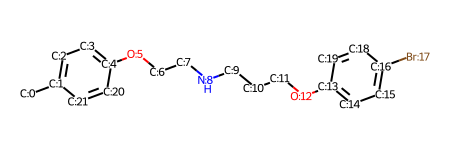

将第0个原子修改为N的分子： Nc1ccc(OCCNCCCOc2ccc(Br)cc2)cc1


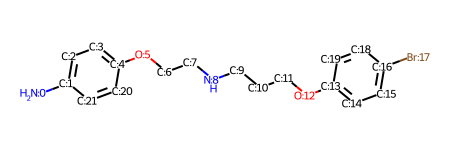

高活性分子： Cc1ccc(OCCNCCCOc2ccc(F)cc2)cc1


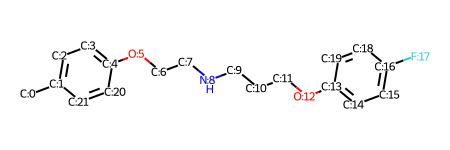

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C':

原子位7生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 8 rank: 0
原子位1生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
第16个原子符号修改为F不符合规范，生成下一个元素……
i: 5 top_idx: 13 rank: 1
原子位16生成At元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
第3个原子符号修改为F不符合规范，生成下一个元素……
i: 5 top_idx: 16 rank: 1
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I

原子位13生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位14生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 18 rank: 0
原子位7生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 19 rank: 0
原子位10生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 20 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 21 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 22 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 23 rank: 0
原子位25生成F元素的置信度小于0.001，

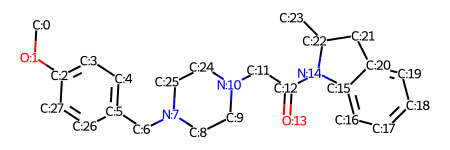

将第23个原子修改为N的分子： COc1ccc(CN2CCN(CC(=O)N3c4ccccc4CC3N)CC2)cc1


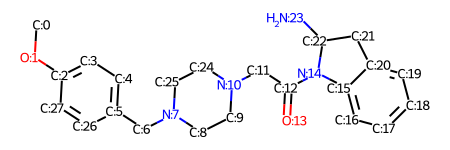

高活性分子： Cc1ccc(CN2CCN(CC(=O)N3c4ccccc4CC3C)CC2)cc1


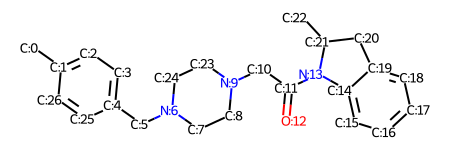

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#13(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#23(f): {'B': 0.0, 'C': 0.993, 'N': 

修改前的分子： COc1ccc(CN2CCN(CC(=O)N3c4ccccc4CC3C)CC2)cc1


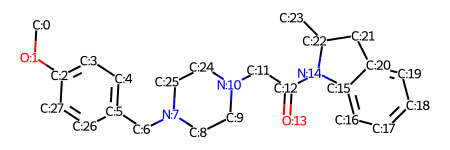

将第23个原子修改为N的分子： COc1ccc(CN2CCN(CC(=O)N3c4ccccc4CC3N)CC2)cc1


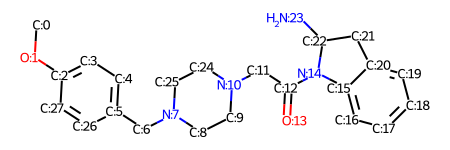

高活性分子： COc1ccc(CN2CCC(CC(=O)N3c4ccccc4CC3C)CC2)cc1


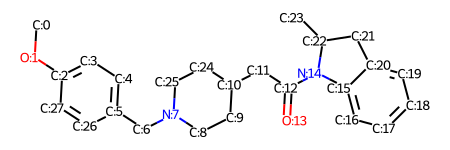

atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.996, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 0.001, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.0, 'C': 0.001, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C':

原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 1 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位1生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位15生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位22生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位6生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子

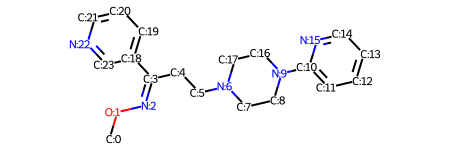

将第0个原子修改为F的分子： FON=C(CCN1CCN(c2ccccn2)CC1)c1cccnc1


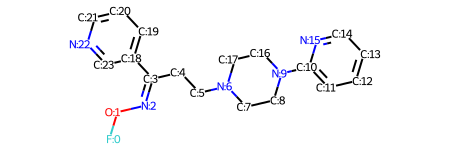

高活性分子： CON=C(CCN1CCN(c2ccccn2)CC1)c1ccccc1


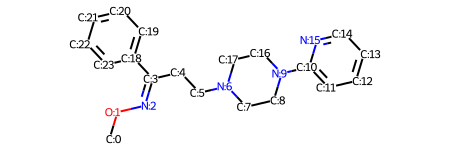

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0, 'C': 0.0,

i: 9 top_idx: 2 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 3 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 4 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 5 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 6 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 7 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 8 rank: 0
原子位24生成O元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 9 rank: 0
原子位3生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 10 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 11 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 12 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 13 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 14 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 15 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 16 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 17 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 18 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 19 rank: 0
原子

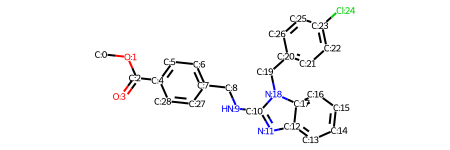

将第10个原子修改为At的分子： COC(=O)c1ccc(CN[At]2NC3CCCCC3N2Cc2ccc(Cl)cc2)cc1


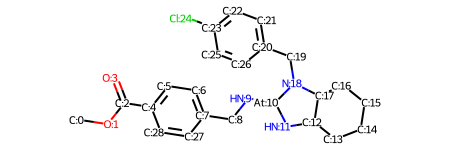

高活性分子： COC(=O)c1ccc(CCc2nc3ccccc3n2Cc2ccc(Cl)cc2)cc1


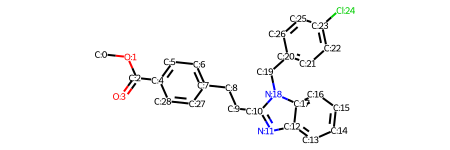

congratulations: [1] [28]
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.002, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f

原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 3 rank: 0
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 4 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 5 rank: 0
原子位12生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 6 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 7 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 8 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 9 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 10 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 11 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 12 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 13 rank: 0
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 14 rank: 0
原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 15 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 16 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 17 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 18 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 19 rank: 0
修改前的分子： CCN(C)CCc1c(-c2ccco2

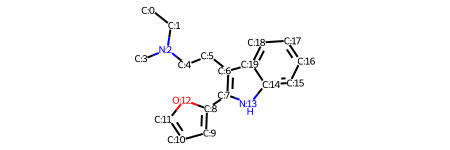

将第3个原子修改为F的分子： CCN(F)CCc1c(-c2ccco2)[nH]c2ccccc12


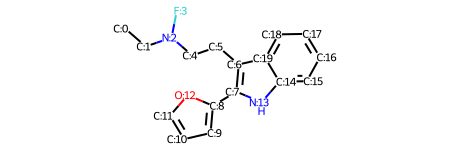

高活性分子： CCN(C)CCc1c(-c2cccs2)[nH]c2ccccc12


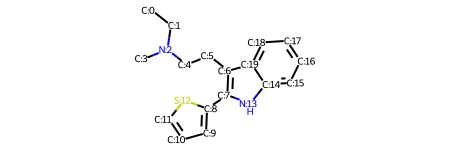

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 

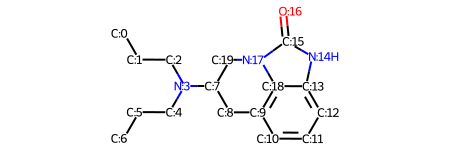

将第18个原子修改为S的分子： CCCN(CCC)C1CC2=S3C(=CC=C2)NC(=O)N3C1


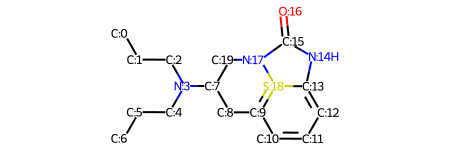

高活性分子： CCCN(CCC)C1Cc2cccc3[nH]c(=S)n(c23)C1


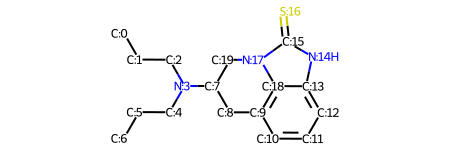

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 0.

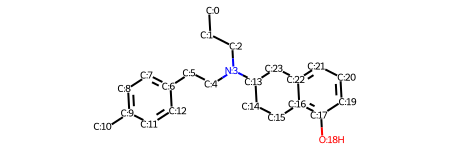

将第10个原子修改为N的分子： CCCN(CCc1ccc(N)cc1)C1CCc2c(O)cccc2C1


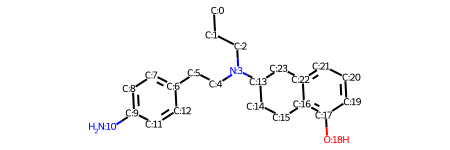

高活性分子： CCCN(CCc1ccc(N)cc1)C1CCc2c(O)cccc2C1


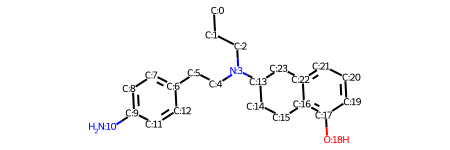

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.977, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.018, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.002, 'C': 0.024, 'N': 0.038, 'O': 0.687, 'F': 0.005, 'Si': 0.002, 'P': 0.002, 'S': 0.047, 'Cl': 0.0, 'As': 0.002, 'Se': 0.002, 'Br': 0.145, 'Te': 0.002, 'I': 0.003, 'At': 0.002, 'other': 0.034} 
------------------------------------------------------------------------------------------------------------


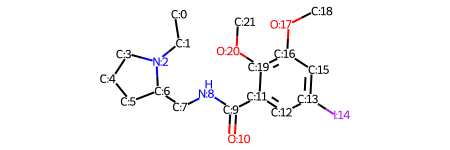

将第4个原子修改为S的分子： CCN1CSCC1CNC(=O)c1cc(I)cc(OC)c1OC


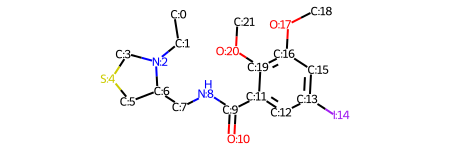

高活性分子： CCN1CCCC1CNC(=O)c1cc(Br)cc(OC)c1OC


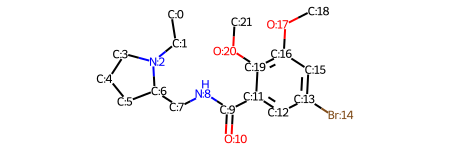

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 0.987, 'N

原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 3 rank: 0
原子位7生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 4 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 5 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 6 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 7 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 8 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 9 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 10 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 11 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 12 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 13 rank: 0
原子位0生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 15 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 16 rank: 0
原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 17 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 18 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 19 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子

原子位1生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 1 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 2 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 3 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 4 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 5 rank: 0
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 6 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 7 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 8 rank: 0
原子位18生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位29生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子

原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 1 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 2 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 3 rank: 0
原子位9生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 4 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 5 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位7生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
第12个原子符号修改为F不符合规范，生成下一个元素……
i: 6 top_idx: 11 rank: 1
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
第10个原子符号修改为F不符合规范，生成下一个元素……
i: 6 top_idx: 14 rank: 1
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
第6个原子符号修改为F不符合规范，生成下一个元素……
i: 6 top_id

原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 22 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 23 rank: 0
原子位15生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 24 rank: 0
修改前的分子： CC1CC(=O)Nc2c(CCN3CCN(c4noc5ccccc45)CC3)cc(F)cc21


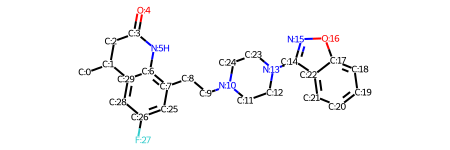

将第0个原子修改为N的分子： NC1CC(=O)Nc2c(CCN3CCN(c4noc5ccccc45)CC3)cc(F)cc21


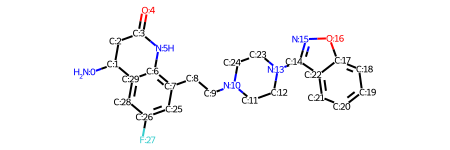

高活性分子： Cc1cc(CCN2CCN(c3noc4ccccc34)CC2)c2c(c1)C(C)CC(=O)N2


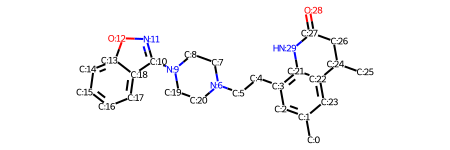

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#17(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 1.0

原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位17生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位28生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 18 rank: 0
原子位5生成F元素的置信度小于0.001，寻找

atom#4(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

原子位2生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 1 rank: 0
原子位45生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 2 rank: 0
原子位34生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 3 rank: 0
原子位36生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 4 rank: 0
原子位47生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 5 rank: 0
原子位46生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 6 rank: 0
原子位35生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 7 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 8 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 9 rank: 0
原子位92生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 10 rank: 0
原子位51生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 11 rank: 0
原子位40生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 12 rank: 0
原子位6生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 13 rank: 0
原子位29生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 14 rank: 0
原子位15生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 15 rank: 0
原子位104生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 16 rank: 0
原子位62生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 17 rank: 0
原子位74生成N元素的置信度小

修改前的分子： CC(C)CS(=O)(=O)n1ccc2c(-c3cccnc3)cc(N3CCN(C)CC3)nc21


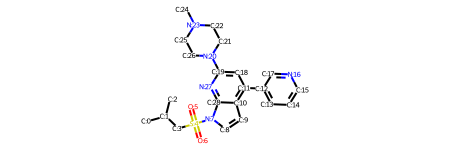

将第3个原子修改为N的分子： CC(C)NS(=O)(=O)n1ccc2c(-c3cccnc3)cc(N3CCN(C)CC3)nc21


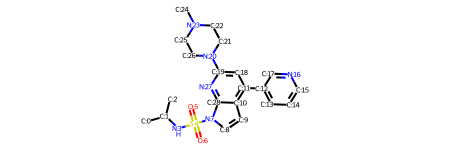

高活性分子： CC(C)CS(=O)(=O)n1ccc2c(-c3ccccc3)cc(N3CCN(C)CC3)nc21


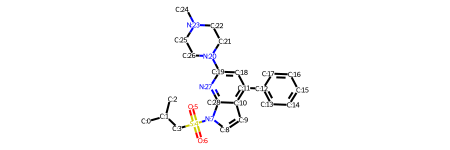

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 1.0, 'N': 0.0

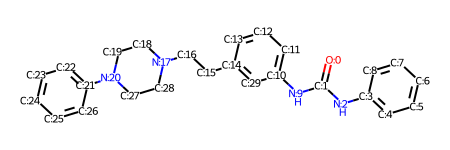

将第1个原子修改为At的分子： O=[AtH](Nc1ccccc1)Nc1cccc(CCN2CCN(c3ccccc3)CC2)c1


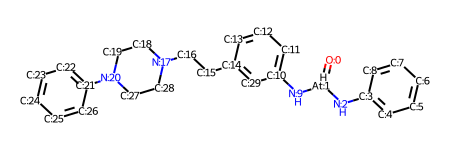

高活性分子： O=C(Nc1cccnc1)Nc1cccc(CCN2CCN(c3ccccc3)CC2)c1


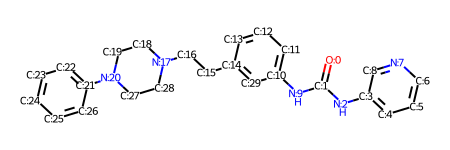

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.001, 'N': 0.0, 'O': 0.998, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.999, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.997, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 

修改前的分子： OC1(c2ccc(Cl)c(Cl)c2)CC2CCC(C1)N2Cc1csc2ccccc12


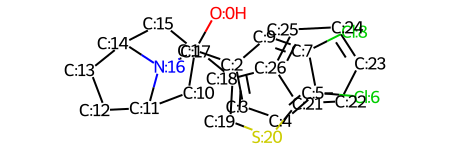

将第17个原子修改为N的分子： OC1(c2ccc(Cl)c(Cl)c2)CC2CCC(C1)N2Nc1csc2ccccc12


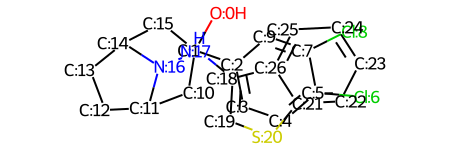

高活性分子： OC1(c2ccc(Cl)c(Cl)c2)CC2CCC(C1)N2Cc1coc2ccccc12


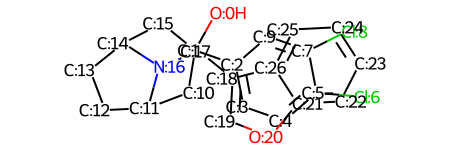

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#15(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0.0

原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 1 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 2 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 3 rank: 0
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 4 rank: 0
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 5 rank: 0
原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 6 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 7 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 8 rank: 0
原子位15生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 9 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 10 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
第6个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 14 rank: 1
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位4生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 t

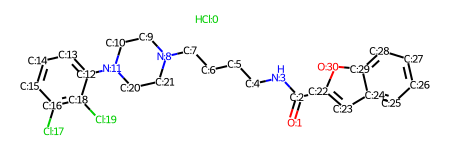

将第30个原子修改为S的分子： Cl.O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccccc2s1


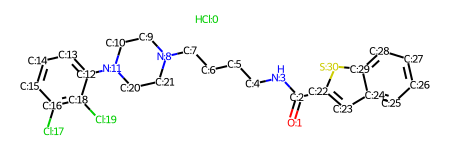

高活性分子： Cl.O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccccc2s1


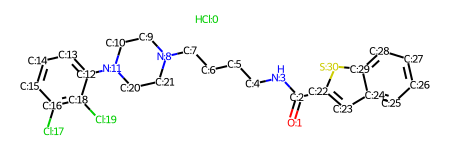

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#23(f): {'B': 0.0, 'C': 0.0, 'N': 0.0,

原子位2生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 2 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 3 rank: 0
原子位30生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 4 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 5 rank: 0
原子位31生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 6 rank: 0
原子位12生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 7 rank: 0
原子位23生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 8 rank: 0
原子位32生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 18 rank: 0
原子位27生成F元素的置信度小于0.001，寻找下一

原子位14生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 4 rank: 0
原子位15生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 5 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位3生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
第20个原子符号修改为F不符合规范，生成下一个元素……
i: 6 top_idx: 13 rank: 1
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 18 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 19 rank: 0
第19个原子符号修改为Cl不符合规范，生成下一个元素……
i:

原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 1 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位11生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位16生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位

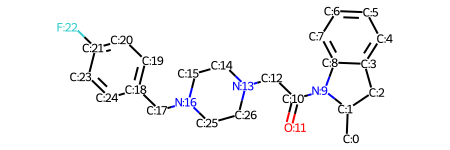

将第22个原子修改为C的分子： Cc1ccc(CN2CCN(CC(=O)N3c4ccccc4CC3C)CC2)cc1


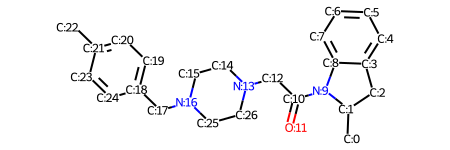

高活性分子： CC1Cc2ccccc2N1C(=O)CC1CCN(Cc2ccc(F)cc2)CC1


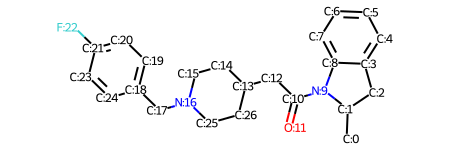

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#17(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N':

i: 9 top_idx: 16 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 17 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 18 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 19 rank: 0
原子位10生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 20 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 21 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 22 rank: 0
原子位7生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 23 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 24 rank: 0
第11个原子符号修改为F不符合规范，生成下一个元素……
i: 9 top_idx: 24 rank: 1
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 25 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 26 rank: 0
原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 27 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 28 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 29 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
congratulations: [3] [38]
atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0

atom#27(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#27(f+d): {'B': 0.0, 'C': 0.995, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#28(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#28(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C': 0.

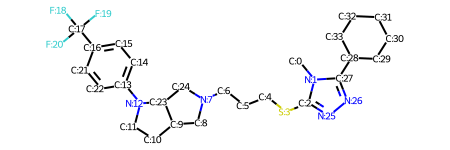

将第20个原子修改为N的分子： Cn1c(SCCCN2CC3CCN(c4ccc(C(N)(F)F)cc4)C3C2)nnc1C1CCCCC1


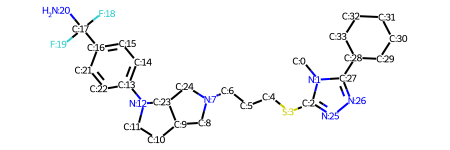

高活性分子： Cn1c(SCCCN2CC3CCN(c4ccc(C(F)(F)F)cc4)C3C2)nnc1C1CCCC1


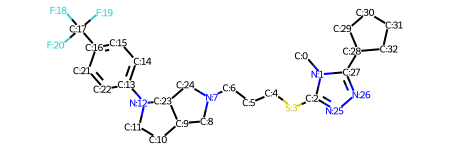

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0,

i: 1 top_idx: 10 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 11 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 12 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 13 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 14 rank: 0
原子位15生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 15 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 16 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 17 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 18 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 19 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 20 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 21 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 22 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 23 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 24 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 25 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 26 rank: 0
原子位24生成C元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(

atom#4(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#5(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.998, 

atom#0(f): {'B': 0.0, 'C': 0.959, 'N': 0.0, 'O': 0.012, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.025, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.959, 'N': 0.0, 'O': 0.012, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.025, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0, 'C'

i: 5 top_idx: 0 rank: 0
原子位23生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 1 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 2 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 3 rank: 0
原子位7生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 4 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 5 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 6 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 7 rank: 0
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 8 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
原子位

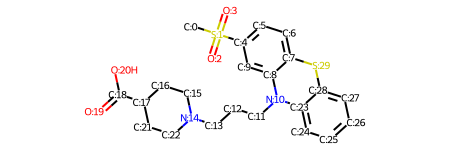

将第23个原子修改为S的分子： CS(=O)(=O)c1ccc2c(c1)N(CCCN1CCC(C(=O)O)CC1)S1=CC=CC=C1S2


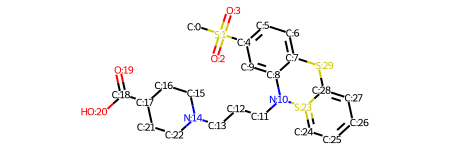

高活性分子： CS(=O)(=O)c1ccc2c(c1)N(CCCN1CCC(C(N)=O)CC1)c1ccccc1S2


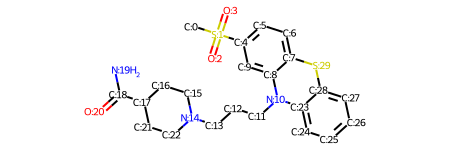

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.9

原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 2 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 3 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 4 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 5 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 6 rank: 0
原子位4生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 7 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 8 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 9 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 10 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 11 rank: 0
原子位28生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 12 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 13 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 14 rank: 0
原子位5生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 15 rank: 0
原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 16 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 17 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 18 rank: 0
原子位10生成C元素的置信度小于0.001，寻找下一个原

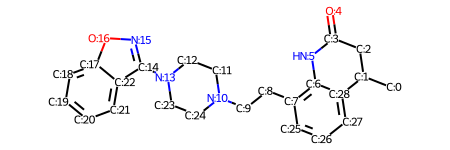

将第0个原子修改为N的分子： NC1CC(=O)Nc2c(CCN3CCN(c4noc5ccccc45)CC3)cccc21


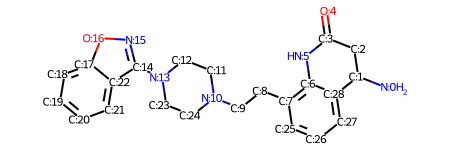

高活性分子： CC1CC(=O)Nc2c(CCN3CCN(c4nsc5ccccc45)CC3)cccc21


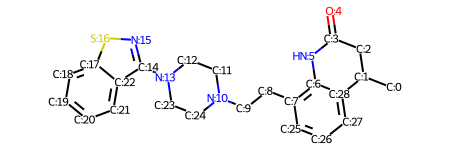

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#14(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0.0

原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位3生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
第5个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 14 rank: 1
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------

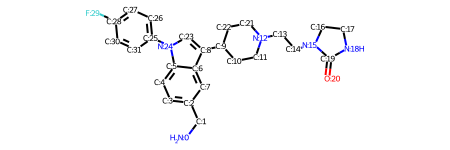

将第29个原子修改为N的分子： NCc1ccc2c(c1)c(C1CCN(CCN3CCNC3=O)CC1)cn2-c1ccc(N)cc1


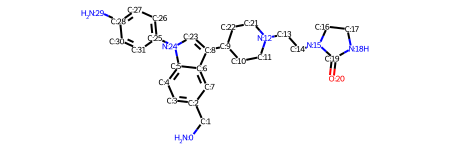

高活性分子： O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1


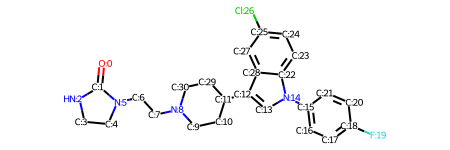

congratulations: [3] [42]
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.999, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#16(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.997, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------


atom#21(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#21(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#24(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#25(f): {'B': 0.0, 'C': 1.0, 'N': 

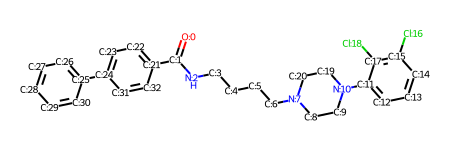

将第18个原子修改为O的分子： O=C(NCCCCN1CCN(c2cccc(Cl)c2O)CC1)c1ccc(-c2ccccc2)cc1


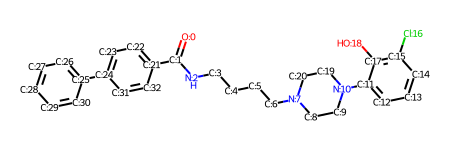

高活性分子： O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc(-c2cccnc2)cc1


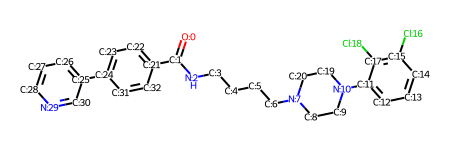

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N

原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 1 rank: 0
原子位7生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 2 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 3 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 4 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 5 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 6 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 7 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 8 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 9 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 10 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 11 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 12 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 13 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 14 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 15 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 16 rank: 0
修改前的分子： Cc1cccc(C(=O)NCN2CCC(c3ccccn3)CC2)c1


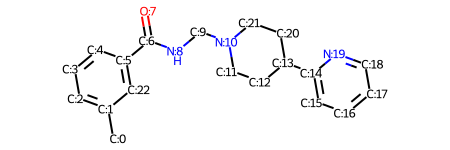

将第0个原子修改为N的分子： Nc1cccc(C(=O)NCN2CCC(c3ccccn3)CC2)c1


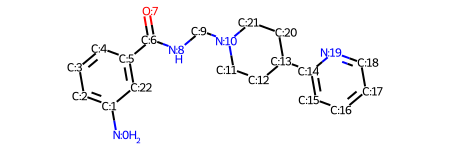

高活性分子： Cc1cccc(C(=O)NCN2CCC(c3ccccc3)CC2)c1


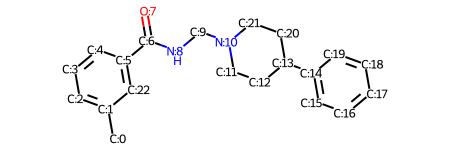

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 1.0, 'N': 0.0,

atom#0(f): {'B': 0.0, 'C': 0.002, 'N': 0.001, 'O': 0.001, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.98, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.004, 'N': 0.005, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.048, 'As': 0.0, 'Se': 0.0, 'Br': 0.93, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.004} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {

atom#9(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#9(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 0.999, '

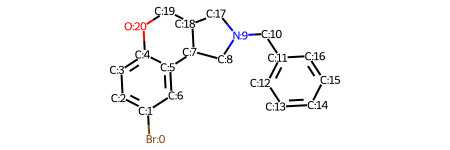

将第0个原子修改为Cl的分子： Clc1ccc2c(c1)C1CN(Cc3ccccc3)CC1CO2


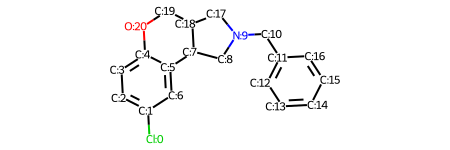

高活性分子： Fc1ccc2c(c1)C1CN(Cc3ccccc3)CC1CO2


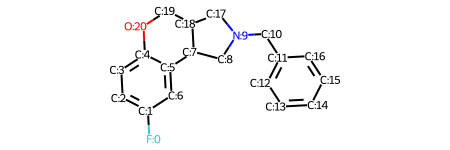

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#15(f+d): {'B': 0.0, 'C': 0.001, 'N': 0.0, 'O': 0.998, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0,

第12个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 15 rank: 1
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 16 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 17 rank: 0
第14个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 17 rank: 1
原子位14生成At元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 18 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 19 rank: 0
第5个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 19 rank: 1
第5个原子符号修改为N不符合规范，生成下一个元素……
i: 4 top_idx: 19 rank: 2
原子位5生成At元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 20 rank: 0
第20个原子符号修改为Cl不符合规范，生成下一个元素……
i: 4 top_idx: 20 rank: 1
第20个原子符号修改为C不符合规范，生成下一个元素……
i: 4 top_idx: 20 rank: 2
原子位20生成S元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 21 rank: 0
第19个原子符号修改为Cl不符合规范，生成下一个元素……
i: 4 top_idx: 21 rank: 1
第19个原子符号修改为C不符合规范，生成下一个元素……
i: 4 top_idx: 21 rank: 2
原子位19生成S元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 22 rank: 0
第18个原子符号修改为Cl不符合规范，生成下一个元素……
i: 4 top_idx: 22 rank: 1
第18个原子符号修改为C不符合规范，生成下一个元素……
i: 4 top_idx: 22 rank: 2
原子位18生成S元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 

原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 1 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 2 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 3 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 4 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 5 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 6 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 7 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 8 rank: 0
原子位29生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个

atom#24(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#24(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#26(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#26(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#27(f): {'B': 0.0, 'C': 1.0, 'N'

第11个原子符号修改为Cl不符合规范，生成下一个元素……
i: 7 top_idx: 0 rank: 1
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 1 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 2 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 3 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 4 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 5 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 6 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 7 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 8 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 9 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 10 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 11 rank: 0
第21个原子符号修改为N不符合规范，生成下一个元素……
i: 7 top_idx: 11 rank: 1
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 12 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 13 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 14 rank: 0
第24个原子符号修改为N不符合规范，生成下一个元素……
i: 7 top_idx: 14 rank: 1
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top

修改前的分子： O=C(NCCC(F)CN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc2c(c1)Cc1ccccc1-2


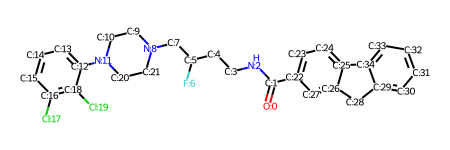

将第6个原子修改为N的分子： NC(CCNC(=O)c1ccc2c(c1)Cc1ccccc1-2)CN1CCN(c2cccc(Cl)c2Cl)CC1


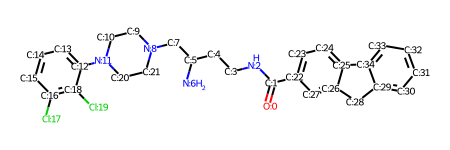

高活性分子： O=C(NCCC(O)CN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc2c(c1)Cc1ccccc1-2


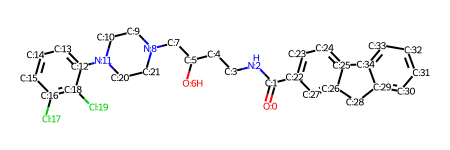

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#22(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.999, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#22(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0, 'C': 

原子位8生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 2 rank: 0
原子位22生成O元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 3 rank: 0
修改前的分子： O=C1CCc2ccc(OCC#CCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1


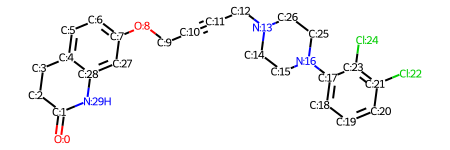

将第24个原子修改为O的分子： O=C1CCc2ccc(OCC#CCN3CCN(c4cccc(Cl)c4O)CC3)cc2N1


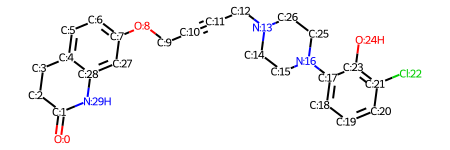

高活性分子： O=C1CCc2ccc(OCC=CCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1


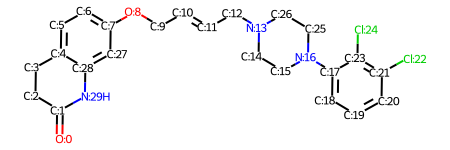

congratulations: [3] [47]
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.001, 'N': 0.0, 'O': 0.997, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#22(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.001, 'F': 0.998, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#22(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.038, 'O': 0.007, 'F': 0.931, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.021, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------

atom#7(f+d): {'B': 0.0, 'C': 0.981, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.013, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.997, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C

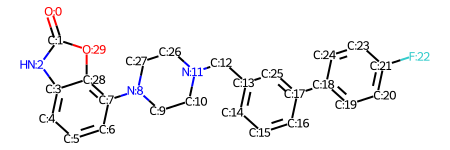

将第22个原子修改为N的分子： Nc1ccc(-c2cccc(CN3CCN(c4cccc5[nH]c(=O)oc45)CC3)c2)cc1


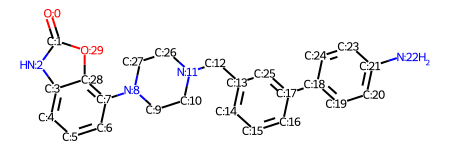

高活性分子： O=c1[nH]c2cccc(N3CCN(Cc4cc(-c5ccc(F)cc5)ccn4)CC3)c2o1


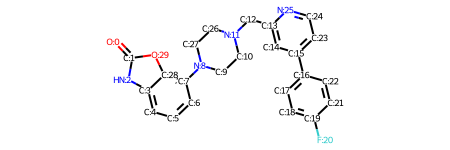

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#18(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 0.0, 'N': 0

原子位27生成O元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 2 rank: 0
原子位1生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 3 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 4 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 5 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 6 rank: 0
原子位18生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 7 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 8 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 9 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 10 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 11 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 12 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 13 rank: 0
原子位11生成O元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 14 rank: 0
原子位16生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 15 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 16 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 17 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 18 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原

第13个原子符号修改为Br不符合规范，生成下一个元素……
i: 3 top_idx: 0 rank: 1
Congratulations! [1] [2]
修改前的分子： CN1CCN(C2=Nc3ccccc3Oc3ccc(Cl)cc32)CC1


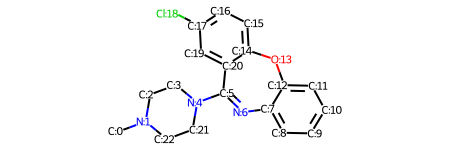

将第13个原子修改为S的分子： CN1CCN(C2=Nc3ccccc3Sc3ccc(Cl)cc32)CC1


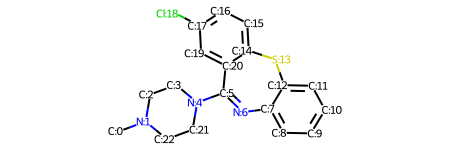

高活性分子： CN1CCN(C2=Nc3ccccc3Sc3ccc(Cl)cc32)CC1


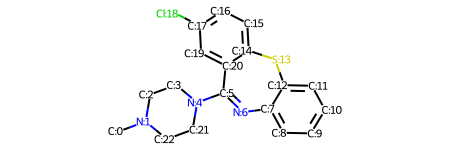

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 0.0, 'N': 0.0

原子位4生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 1 rank: 0
第9个原子符号修改为Cl不符合规范，生成下一个元素……
i: 4 top_idx: 1 rank: 1
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 2 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 3 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 4 rank: 0
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 5 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 6 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 7 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 8 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 9 rank: 0
原子位0生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 10 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 11 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 12 rank: 0
原子位25生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 13 rank: 0
第3个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 13 rank: 1
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 15 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_

原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 4 rank: 0
原子位8生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 5 rank: 0
原子位25生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位15生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 18 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 19 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 20 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一

原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 25 rank: 0
原子位30生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 26 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 27 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 28 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 29 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 30 rank: 0
第26个原子符号修改为F不符合规范，生成下一个元素……
i: 7 top_idx: 30 rank: 1
第26个原子符号修改为N不符合规范，生成下一个元素……
i: 7 top_idx: 30 rank: 2
原子位26生成Cl元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#20(f): {'B': 0

i: 8 top_idx: 13 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位27生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 18 rank: 0
原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 19 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 20 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 21 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 22 rank: 0
原子位14生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 23 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 24 rank: 0
原子位10生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 25 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 26 rank: 0
原子位29生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 27 rank: 0
第28个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 27 rank: 1
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 28 rank: 0
第16个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 28 rank: 1
原子位

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.003, 'N': 0.0, 'O': 0.992, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.001, 'F': 0.998, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.093, 'O': 0.001, 'F': 0.891, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.015, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0

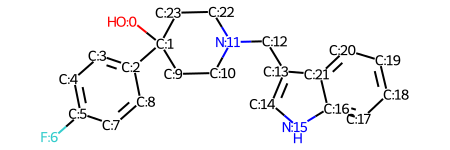

将第6个原子修改为N的分子： Nc1ccc(C2(O)CCN(Cc3c[nH]c4ccccc34)CC2)cc1


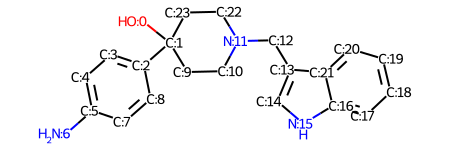

高活性分子： OC1(c2ccc(I)cc2)CCN(Cc2c[nH]c3ccccc23)CC1


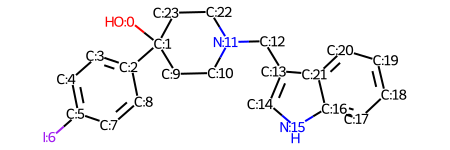

atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.002, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#27(f): {'B': 0.0, 'C': 0.

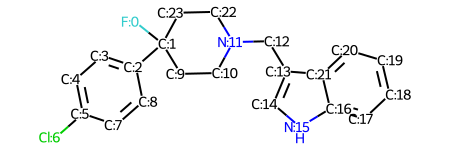

将第0个原子修改为C的分子： CC1(c2ccc(Cl)cc2)CCN(Cc2c[nH]c3ccccc23)CC1


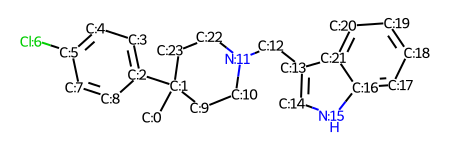

高活性分子： OC1(c2ccc(Cl)cc2)CCN(Cc2c[nH]c3ccccc23)CC1


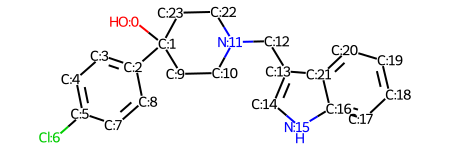

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 1

原子位21生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 5 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 6 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 7 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 8 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 9 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 10 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位1生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位14生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
第15个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 15 rank: 1
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 17 rank: 0
第12个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 17 rank: 1
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 18 rank: 0
第10个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 18 rank: 1
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 to

atom#7(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 1.0, 'N': 

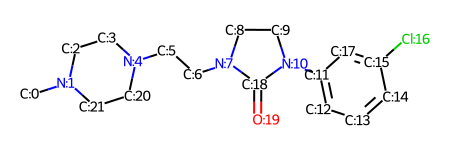

将第19个原子修改为N的分子： CN1CCN(CCN2CCN(c3cccc(Cl)c3)C2=N)CC1


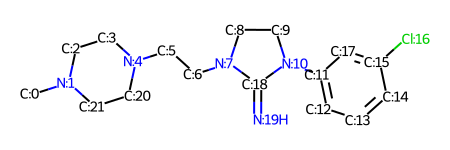

高活性分子： CC1CCN(CCN2CCN(c3cccc(Cl)c3)C2=O)CC1


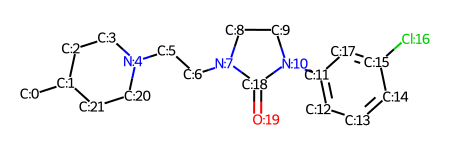

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 18 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 19 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 20 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 21 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 22 rank: 0
原子位19生成C元素的置信度小于0.001，寻

atom#31(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.999, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.999, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
i: 7 top_idx: 0 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 1 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 2 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 3 rank: 0
原子位2生成Cl元素的置信度小于0.001，寻找下一

原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 1 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
原子位17生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位10生成O元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位29生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位4生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
第24个原子符号修改为F不符合规范，生成下一个元素……
i: 8 top_idx: 14 rank: 1
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位6生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位

atom#49(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#53(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#53(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#54(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#54(f+d): {'B': 0.0, 'C': 1.0, 'N'

原子位2生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 1 rank: 0
原子位104生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 2 rank: 0
原子位62生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 3 rank: 0
原子位115生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 4 rank: 0
原子位40生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 5 rank: 0
原子位6生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 6 rank: 0
原子位15生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 7 rank: 0
原子位29生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 8 rank: 0
原子位51生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 9 rank: 0
原子位109生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 10 rank: 0
原子位111生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 11 rank: 0
原子位47生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 12 rank: 0
原子位45生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 13 rank: 0
原子位77生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 14 rank: 0
原子位110生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 15 rank: 0
原子位46生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 16 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 17 rank: 0
原子位23生成N元素

原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 1 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 2 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 3 rank: 0
原子位16生成O元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 4 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 5 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 6 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 7 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 8 rank: 0
原子位18生成O元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 9 rank: 0
原子位26生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 10 rank: 0
原子位30生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 11 rank: 0
原子位32生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 12 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 13 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 14 rank: 0
原子位31生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 15 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 16 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 17 rank: 0
原子位12生成N元素的置信度小于0.001，寻

i: 3 top_idx: 12 rank: 0
原子位24生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 17 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 18 rank: 0
原子位10生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 19 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 20 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 21 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 22 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 23 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 24 rank: 0
第1个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 24 rank: 1
原子位1生成N元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
a

原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 7 rank: 0
第14个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 7 rank: 1
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 8 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 9 rank: 0
第10个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 9 rank: 1
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 10 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 11 rank: 0
第9个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 11 rank: 1
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 12 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 13 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
第11个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 14 rank: 1
第11个原子符号修改为N不符合规范，生成下一个元素……
i: 4 top_idx: 14 rank: 2
原子位11生成Cl元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.992, 'N': 0.0,

Congratulations! [1] [1]
修改前的分子： O=S(=O)(NCCCCN1CCN(c2noc3ccccc23)CC1)c1cccc2scnc12


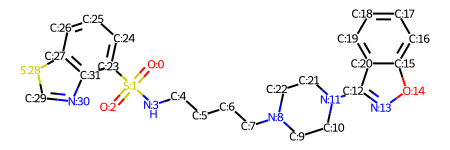

将第14个原子修改为S的分子： O=S(=O)(NCCCCN1CCN(c2nsc3ccccc23)CC1)c1cccc2scnc12


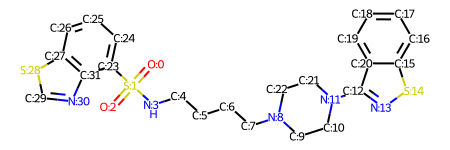

高活性分子： O=S(=O)(NCCCCN1CCN(c2nsc3ccccc23)CC1)c1cccc2scnc12


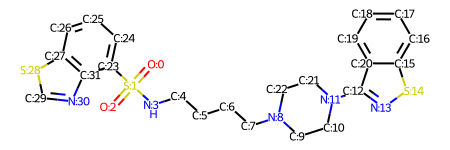

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 1 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, '

atom#7(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#9(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.999, '

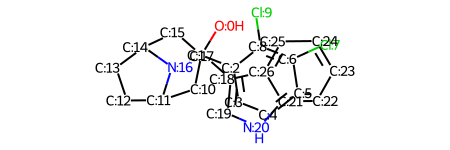

将第21个原子修改为S的分子： OC1(c2cccc(Cl)c2Cl)CC2CCC(C1)N2CC1=CNS2=CC=CC=C12


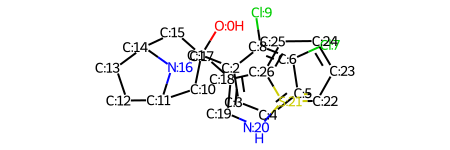

高活性分子： OC1(c2cccc(Cl)c2Cl)CC2CCC(C1)N2Cc1coc2ccccc12


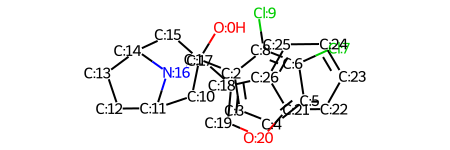

atom#0(f): {'B': 0.0, 'C': 0.996, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.995, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#28(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#28(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0

原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 15 rank: 0
原子位25生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 16 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 17 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 18 rank: 0
原子位30生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 19 rank: 0
原子位12生成C元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 20 rank: 0
原子位31生成C元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 21 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 22 rank: 0
第2个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 22 rank: 1
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 23 rank: 0
原子位32生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 24 rank: 0
第14个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 24 rank: 1
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 25 rank: 0
原子位29生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 26 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 27 rank: 0
第20个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 27 rank: 1
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 28 rank: 0
第0个原子符号修改为N不符合规范，生成下一个元素……
i: 

原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 1 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 2 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 3 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 4 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 5 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 6 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 7 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 8 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 9 rank: 0
原子位1生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 10 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
第18个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 14 rank: 1
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i:

修改前的分子： Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21


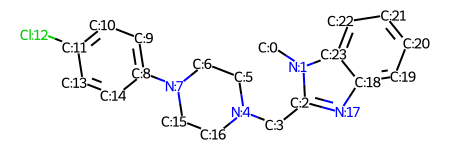

将第12个原子修改为O的分子： Cn1c(CN2CCN(c3ccc(O)cc3)CC2)nc2ccccc21


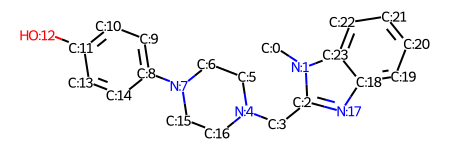

高活性分子： Cn1c(CN2CCC(c3ccc(Cl)cc3)CC2)nc2ccccc21


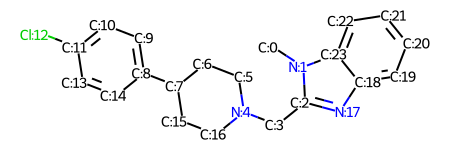

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

i: 6 top_idx: 8 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 18 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 19 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 20 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 21 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 22 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 23 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 24 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 25 rank

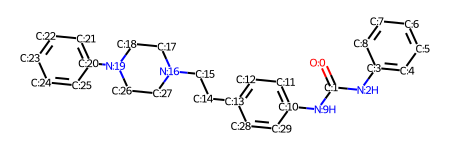

将第1个原子修改为At的分子： O=[AtH](Nc1ccccc1)Nc1ccc(CCN2CCN(c3ccccc3)CC2)cc1


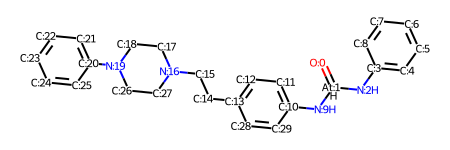

高活性分子： O=C(Nc1ccc(CCN2CCN(c3ccccc3)CC2)cc1)Nc1cccnc1


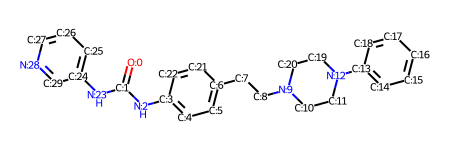

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

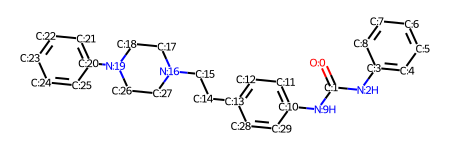

将第1个原子修改为At的分子： O=[AtH](Nc1ccccc1)Nc1ccc(CCN2CCN(c3ccccc3)CC2)cc1


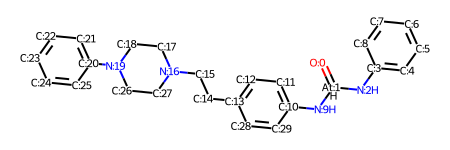

高活性分子： O=C(Nc1ccncc1)Nc1ccc(CCN2CCN(c3ccccc3)CC2)cc1


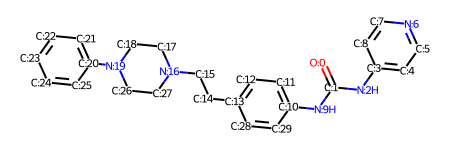

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.0, 'F': 0.997, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#14(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.0, 'F': 0.997, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#19(f): {'B': 0.0, 'C': 

原子位1生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 1 rank: 0
原子位30生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 2 rank: 0
原子位29生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位19生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位31生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位32生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位17生成C元素的置信度小于0.001，寻找下一个原

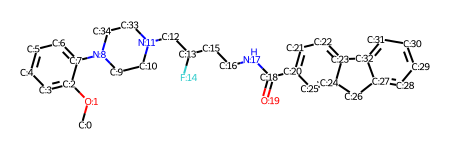

将第14个原子修改为C的分子： COc1ccccc1N1CCN(CC(C)CCNC(=O)c2ccc3c(c2)Cc2ccccc2-3)CC1


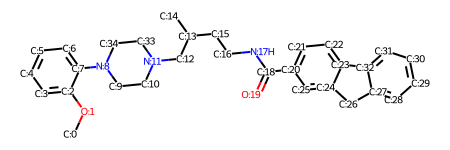

高活性分子： COc1ccccc1N1CCN(CC(O)CCNC(=O)c2ccc3c(c2)Cc2ccccc2-3)CC1


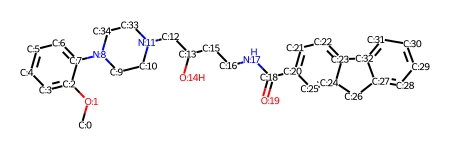

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#13(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 0.0,

原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 8 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 9 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 10 rank: 0
原子位3生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 11 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 12 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 13 rank: 0
第17个原子符号修改为F不符合规范，生成下一个元素……
i: 9 top_idx: 13 rank: 1
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 14 rank: 0
第5个原子符号修改为F不符合规范，生成下一个元素……
i: 9 top_idx: 14 rank: 1
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 15 rank: 0
原子位2生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 16 rank: 0
第13个原子符号修改为N不符合规范，生成下一个元素……
i: 9 top_idx: 16 rank: 1
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 17 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 18 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
congratulations: [5] [58]
atom#0(f): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.

第24个原子符号修改为Cl不符合规范，生成下一个元素……
i: 0 top_idx: 21 rank: 1
第24个原子符号修改为C不符合规范，生成下一个元素……
i: 0 top_idx: 21 rank: 2
原子位24生成S元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 22 rank: 0
原子位25生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 23 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 24 rank: 0
原子位26生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 25 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 26 rank: 0
第0个原子符号修改为N不符合规范，生成下一个元素……
i: 0 top_idx: 26 rank: 1
第0个原子符号修改为F不符合规范，生成下一个元素……
i: 0 top_idx: 26 rank: 2
原子位0生成At元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
-----------------------------------------------------------------------------------

原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 1 rank: 0
原子位15生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 2 rank: 0
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 3 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 4 rank: 0
原子位3生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 5 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 6 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 7 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 8 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 9 rank: 0
第16个原子符号修改为F不符合规范，生成下一个元素……
i: 1 top_idx: 9 rank: 1
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 10 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 11 rank: 0
第8个原子符号修改为F不符合规范，生成下一个元素……
i: 1 top_idx: 11 rank: 1
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 12 rank: 0
原子位9生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 13 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 14 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 15 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_id

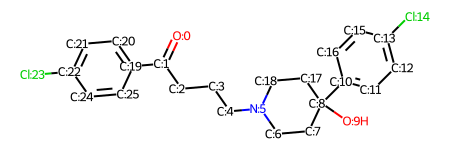

将第9个原子修改为Br的分子： O=C(CCCN1CCC(Br)(c2ccc(Cl)cc2)CC1)c1ccc(Cl)cc1


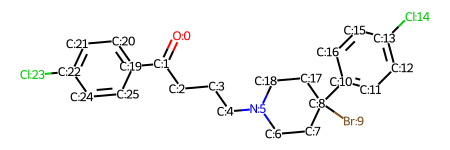

高活性分子： O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1


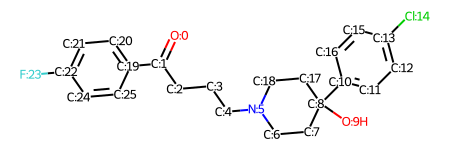

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#9(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 0.0, '

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.999, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#16(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 

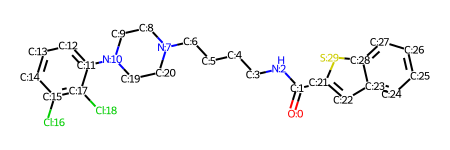

将第18个原子修改为O的分子： O=C(NCCCCN1CCN(c2cccc(Cl)c2O)CC1)c1cc2ccccc2s1


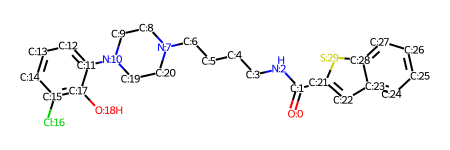

高活性分子： O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccccc2[nH]1


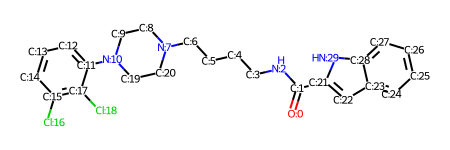

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.999, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#16(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 

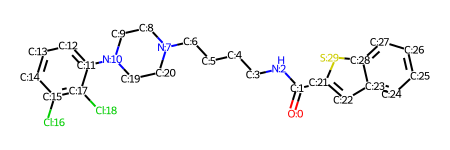

将第18个原子修改为O的分子： O=C(NCCCCN1CCN(c2cccc(Cl)c2O)CC1)c1cc2ccccc2s1


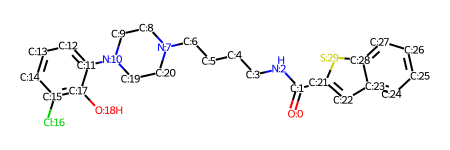

高活性分子： O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccccc2o1


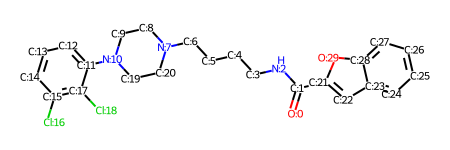

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.001, 'F': 0.997, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#13(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.001, 'F': 0.997, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B'

原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 2 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 3 rank: 0
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 4 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 5 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位20生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位1生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位7生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位4生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位26生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 18 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原

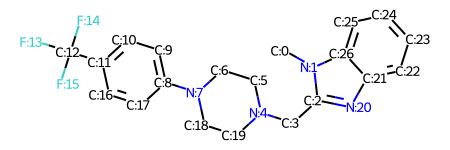

将第15个原子修改为Cl的分子： Cn1c(CN2CCN(c3ccc(C(F)(F)Cl)cc3)CC2)nc2ccccc21


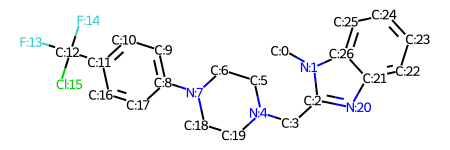

高活性分子： Cn1c(CN2CCC(c3ccc(C(F)(F)F)cc3)CC2)nc2ccccc21


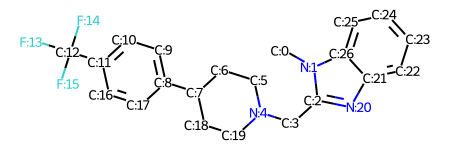

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#13(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0

atom#1(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

原子位19生成At元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.0, 'F': 0.997, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.0, 'F': 0.997, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
--------------------------------------------------------------------------------------------

i: 9 top_idx: 2 rank: 0
原子位17生成O元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 3 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 4 rank: 0
原子位19生成O元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 5 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 6 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 7 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 8 rank: 0
原子位30生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 9 rank: 0
原子位29生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 10 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 11 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 12 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 13 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 14 rank: 0
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 15 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 16 rank: 0
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 17 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 18 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 9 top_idx: 19 rank: 

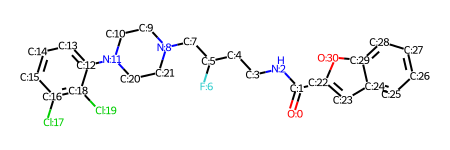

将第6个原子修改为C的分子： CC(CCNC(=O)c1cc2ccccc2o1)CN1CCN(c2cccc(Cl)c2Cl)CC1


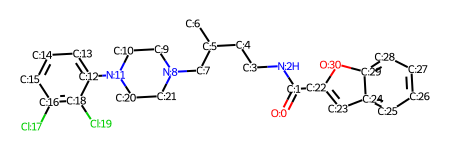

高活性分子： O=C(NCCC(F)CN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccccc2s1


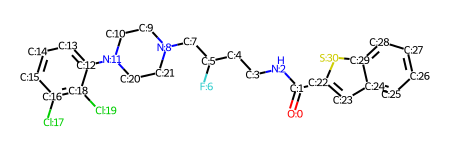

congratulations: [5] [63]
atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.998, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#16(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.001, 'F': 0.998, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
---------------------------------------------------------------------------------------------------

原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 13 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 14 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 15 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 16 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 17 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 18 rank: 0
原子位6生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 19 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 20 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 21 rank: 0
修改前的分子： CC(Nc1ccnc(NCCOc2ccc(F)cc2)n1)c1ccccc1


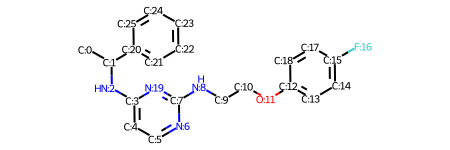

将第0个原子修改为N的分子： NC(Nc1ccnc(NCCOc2ccc(F)cc2)n1)c1ccccc1


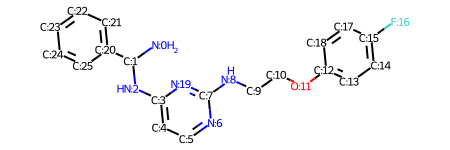

高活性分子： CC(Nc1ccnc(NCCOc2ccc(F)cc2)c1)c1ccccc1


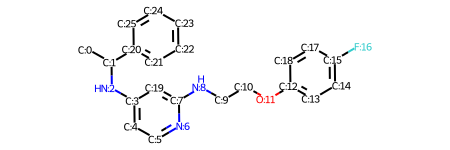

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.001, 'F': 0.998, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.007, 'O': 0.0, 'F': 0.987, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C'

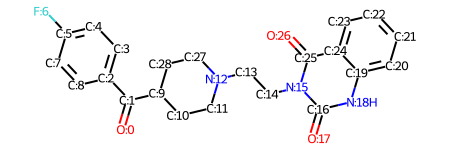

将第6个原子修改为N的分子： Nc1ccc(C(=O)C2CCN(CCn3c(=O)[nH]c4ccccc4c3=O)CC2)cc1


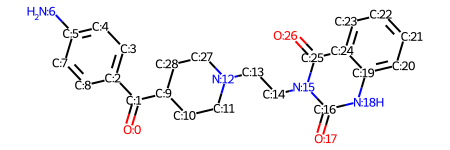

高活性分子： O=C(c1ccc(F)cc1)C1CCN(CCn2c(=S)[nH]c3ccccc3c2=O)CC1


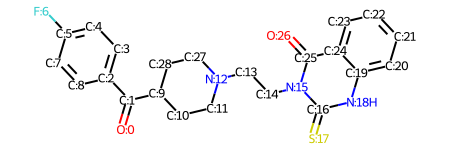

atom#0(f): {'B': 0.0, 'C': 0.454, 'N': 0.0, 'O': 0.319, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.042, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.18, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.002} 
atom#0(f+d): {'B': 0.0, 'C': 0.454, 'N': 0.0, 'O': 0.319, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.042, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.18, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C

原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 19 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 20 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 21 rank: 0
第13个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 21 rank: 1
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 22 rank: 0
第0个原子符号修改为N不符合规范，生成下一个元素……
i: 2 top_idx: 22 rank: 1
第0个原子符号修改为Cl不符合规范，生成下一个元素……
i: 2 top_idx: 22 rank: 2
第0个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 22 rank: 3
第0个原子符号修改为At不符合规范，生成下一个元素……
i: 2 top_idx: 22 rank: 4
第0个原子符号修改为Se不符合规范，生成下一个元素……
i: 2 top_idx: 22 rank: 5
原子位0生成As元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
-------------------------------------

atom#14(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#14(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#15(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C': 0.0, 'N': 

i: 4 top_idx: 13 rank: 0
原子位17生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
原子位20生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 15 rank: 0
原子位6生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 16 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 17 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 18 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 19 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 20 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 21 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 22 rank: 0
原子位24生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 23 rank: 0
修改前的分子： COc1ccc(N2CCN(CCOc3ccc4[nH]c(=O)[nH]c4c3)CC2)cc1


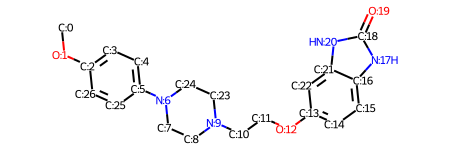

将第10个原子修改为N的分子： COc1ccc(N2CCN(NCOc3ccc4[nH]c(=O)[nH]c4c3)CC2)cc1


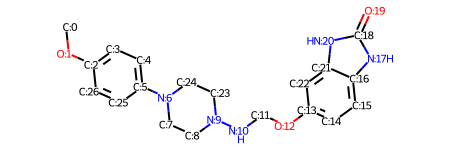

高活性分子： COc1ccc(N2CCN(CCOc3ccc4[nH]c(=S)[nH]c4c3)CC2)cc1


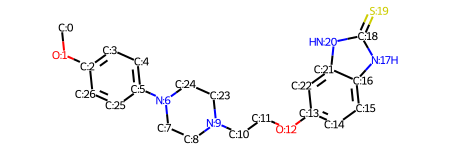

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 

原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 1 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 2 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 3 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 4 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 5 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 6 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 7 rank: 0
原子位7生成O元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 8 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
第11个原子符号修改为Cl不符合规范，生成下一个元素……
i:

i: 6 top_idx: 0 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 1 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 2 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 3 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 4 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 5 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位28生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 16 rank: 0
原子位11生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 17 rank: 0
原子位29

atom#27(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#27(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#31(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#31(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#33(f): {'B': 0.0, 'C': 1.0, '

修改前的分子： CC(O)C1NC(=O)C(CCCCN)NC(=O)C(Cc2c[nH]c3ccccc23)NC(=O)C(Cc2ccncc2)NC(=O)C(Cc2ccccc2)NC(=O)C(CCCNC(=N)N)NC(=O)C(NCC(Cc2ccc(O)cc2)NC(=O)CSCC2CC3c4cccc5[nH]cc(c45)CC3N(C)C2)CCCCNC(=O)C(Cc2ccccc2)NC1=O


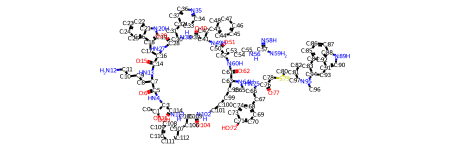

将第57个原子修改为S的分子： CC(O)C1NC(=O)C(CCCCN)NC(=O)C(Cc2c[nH]c3ccccc23)NC(=O)C(Cc2ccncc2)NC(=O)C(Cc2ccccc2)NC(=O)C(CCCNS(=N)N)NC(=O)C(NCC(Cc2ccc(O)cc2)NC(=O)CSCC2CC3c4cccc5[nH]cc(c45)CC3N(C)C2)CCCCNC(=O)C(Cc2ccccc2)NC1=O


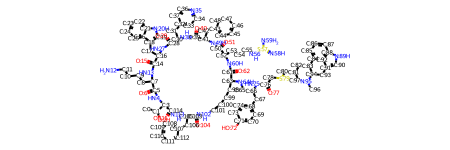

高活性分子： CC(O)C1NC(=O)C(CCCCN)NC(=O)C(Cc2c[nH]c3ccccc23)NC(=O)C(Cc2ccccc2)NC(=O)C(Cc2ccccc2)NC(=O)C(CCCNC(=N)N)NC(=O)C(NCC(Cc2ccc(O)cc2)NC(=O)CSCC2CC3c4cccc5[nH]cc(c45)CC3N(C)C2)CCCCNC(=O)C(Cc2ccccc2)NC1=O


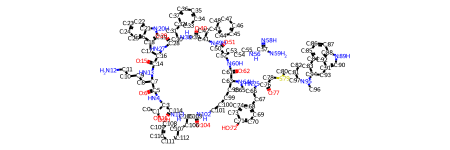

atom#0(f): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0, '

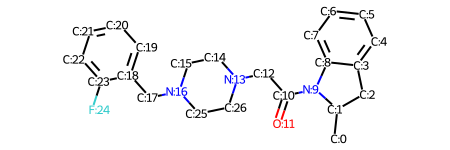

将第0个原子修改为N的分子： NC1Cc2ccccc2N1C(=O)CN1CCN(Cc2ccccc2F)CC1


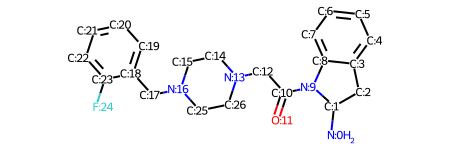

高活性分子： CC1Cc2ccccc2N1C(=O)CN1CCN(Cc2ccccc2Cl)CC1


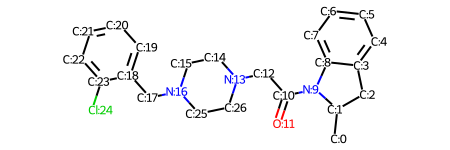

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.998, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 

原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
congratulations: [5] [68]
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#14(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
----------------------------------------------------------------------------

原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 15 rank: 0
第16个原子符号修改为F不符合规范，生成下一个元素……
i: 0 top_idx: 15 rank: 1
原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 16 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 17 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 18 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 19 rank: 0
第19个原子符号修改为Cl不符合规范，生成下一个元素……
i: 0 top_idx: 19 rank: 1
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 20 rank: 0
第18个原子符号修改为Cl不符合规范，生成下一个元素……
i: 0 top_idx: 20 rank: 1
原子位18生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 21 rank: 0
第17个原子符号修改为Cl不符合规范，生成下一个元素……
i: 0 top_idx: 21 rank: 1
原子位17生成C元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.002, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0

原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 10 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 11 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 12 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 13 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 14 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 15 rank: 0
原子位16生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 16 rank: 0
原子位13生成C元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 17 rank: 0
原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 18 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 19 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 20 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 21 rank: 0
原子位25生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 22 rank: 0
原子位26生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 23 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 24 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 1 top_idx: 25 rank: 0
修改前的分子： CC1Cc2ccccc2N1C(=O)CN1CCN(Cc2cccc(F)c2)CC1


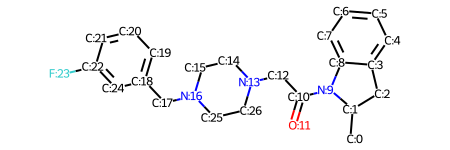

将第23个原子修改为C的分子： Cc1cccc(CN2CCN(CC(=O)N3c4ccccc4CC3C)CC2)c1


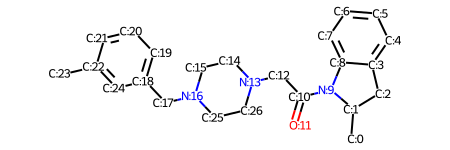

高活性分子： CC1Cc2ccccc2N1C(=O)CC1CCN(Cc2cccc(F)c2)CC1


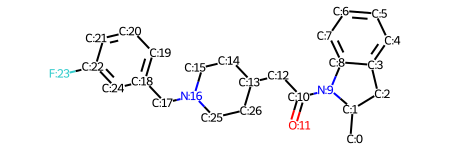

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#13(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.999, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0

第5个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 10 rank: 1
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位3生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
第1个原子符号修改为N不符合规范，生成下一个元素……
i: 3 top_idx: 14 rank: 1
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
第0个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 15 rank: 1
原子位0生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
第13个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 16 rank: 1
第13个原子符号修改为N不符合规范，生成下一个元素……
i: 3 top_idx: 16 rank: 2
原子位13生成Cl元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, '

原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 1 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 2 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 3 rank: 0
原子位8生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 4 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 5 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 6 rank: 0
原子位27生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 7 rank: 0
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 8 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 9 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 10 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 11 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 12 rank: 0
原子位23生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 13 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 15 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 16 rank: 0
原子位1生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 17 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子

atom#27(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#27(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#18(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
i: 5 top_idx: 0 rank: 0
原子位21生成N元素的置信度

原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 1 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 2 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 3 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 4 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 5 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 6 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 7 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 8 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 9 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 10 rank: 0
原子位22生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 11 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 12 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 13 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 14 rank: 0
第21个原子符号修改为F不符合规范，生成下一个元素……
i: 6 top_idx: 14 rank: 1
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 15 rank: 0
第3个原子符号修改为F不符合规范，生成下一个元素……
i: 6 top_idx: 15 rank: 1
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 6 top

原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 1 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 2 rank: 0
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 7 top_idx: 3 rank: 0
修改前的分子： CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1


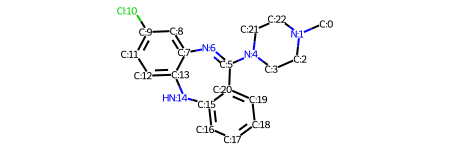

将第10个原子修改为O的分子： CN1CCN(C2=Nc3cc(O)ccc3Nc3ccccc32)CC1


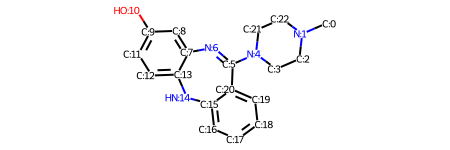

高活性分子： CN1CCN(C2=Nc3cc(Cl)ccc3Oc3ccccc32)CC1


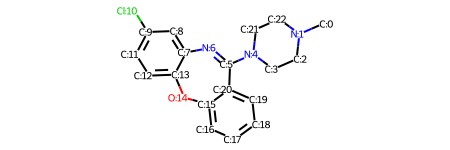

atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#24(f): {'B': 0.0, 'C': 0.0, 'N': 0.0,

原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 3 rank: 0
原子位21生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 4 rank: 0
原子位26生成O元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 5 rank: 0
原子位8生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 6 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 7 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 8 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 9 rank: 0
原子位22生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 10 rank: 0
原子位20生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 11 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 12 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 13 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 14 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 15 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 16 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 17 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 18 rank: 0
原子位18生成C元素的置信度小于0.001，寻找下一个原子位……
i: 8 top_idx: 19 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原

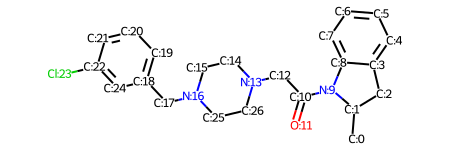

将第0个原子修改为N的分子： NC1Cc2ccccc2N1C(=O)CN1CCN(Cc2cccc(Cl)c2)CC1


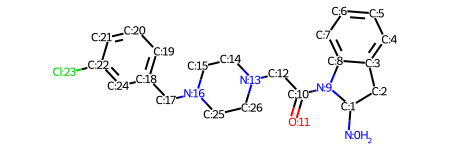

高活性分子： CC1Cc2ccccc2N1C(=O)CC1CCN(Cc2cccc(Cl)c2)CC1


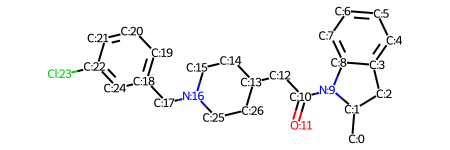

congratulations: [5] [71]
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B':

原子位4生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 13 rank: 0
原子位12生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 14 rank: 0
原子位7生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 15 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 16 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 17 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 18 rank: 0
原子位20生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 19 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 20 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 21 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 22 rank: 0
第10个原子符号修改为F不符合规范，生成下一个元素……
i: 0 top_idx: 22 rank: 1
原子位10生成N元素的置信度小于0.001，寻找下一个原子位……
i: 0 top_idx: 23 rank: 0
第18个原子符号修改为C不符合规范，生成下一个元素……
i: 0 top_idx: 23 rank: 1
原子位18生成Cl元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0

原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 1 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 2 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 3 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 4 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 5 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 6 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 7 rank: 0
原子位0生成C元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 8 rank: 0
原子位2生成C元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 9 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 10 rank: 0
原子位4生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 11 rank: 0
原子位19生成C元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 12 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 13 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 14 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 15 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 16 rank: 0
原子位12生成C元素的置信度小于0.001，寻找下一个原子位……
i: 2 top_idx: 17 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位…

原子位28生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位11生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位6生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 17 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 18 rank: 0
原子位1生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 19 rank: 0
原子位9生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 20 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 21 rank: 0
第15个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 21 rank: 1
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 22 rank: 0
第27个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 22 rank: 1
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 23 rank: 0
第7个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 23 rank: 1
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 24 rank: 0
第0个原子符号修改为N不符合规范，生成下一个元素……
i: 3 top_idx: 24 rank: 1
第0个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 24 rank: 2
原子位0生成At元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 25 rank: 0
第5个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 25 rank: 1
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 26 ran

修改前的分子： S=c1[nH]c2ccc(OCCN3CCN(c4ccc(Cl)cc4)CC3)cc2[nH]1


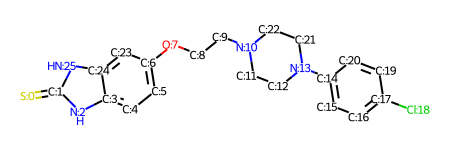

将第1个原子修改为S的分子： S=S1Nc2ccc(OCCN3CCN(c4ccc(Cl)cc4)CC3)cc2N1


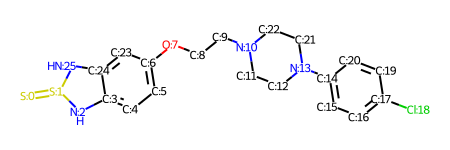

高活性分子： S=c1[nH]c2ccc(CCCN3CCN(c4ccc(Cl)cc4)CC3)cc2[nH]1


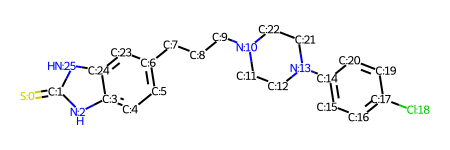

atom#0(f): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.999, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.0, 'N':

atom#13(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#13(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#14(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 

原子位17生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 18 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 19 rank: 0
原子位3生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 20 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 21 rank: 0
原子位18生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 22 rank: 0
原子位5生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 23 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 24 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 6 top_idx: 25 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.985, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.007, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.007, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
ato

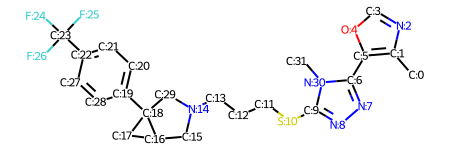

将第26个原子修改为N的分子： Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3ccc(C(N)(F)F)cc3)C2)n1C


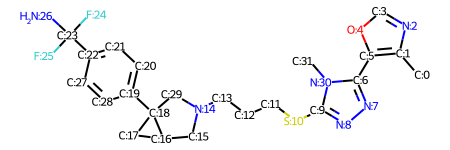

高活性分子： Cc1ccoc1-c1nnc(SCCCN2CC3CC3(c3ccc(C(F)(F)F)cc3)C2)n1C


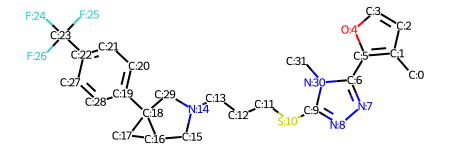

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#19(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#19(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 

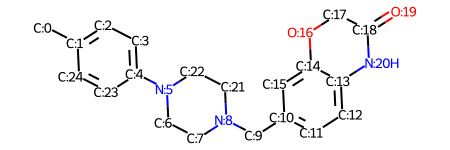

将第0个原子修改为N的分子： Nc1ccc(N2CCN(Cc3ccc4c(c3)OCC(=O)N4)CC2)cc1


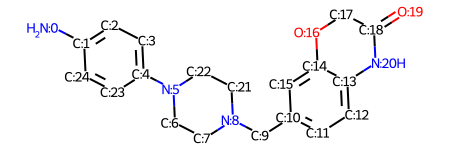

高活性分子： Cc1ccc(C2CCN(Cc3ccc4c(c3)OCC(=O)N4)CC2)cc1


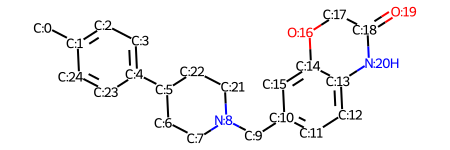

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.0, 'F': 0.997, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.004, 'O': 0.0, 'F': 0.995, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C': 

atom#5(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#5(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.0, 'N': 1.0,

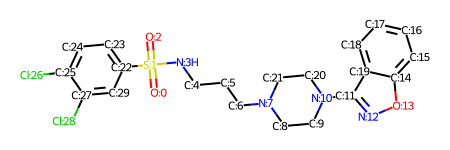

将第13个原子修改为Cl的分子： O=S(=O)(NCCCN1CCN(C2NClC3CCCCC32)CC1)c1ccc(Cl)c(Cl)c1


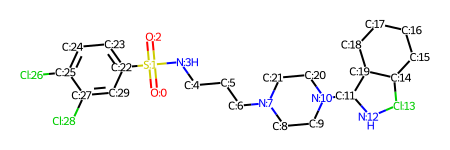

高活性分子： O=S(=O)(NCCCN1CCN(c2nsc3ccccc23)CC1)c1ccc(Cl)c(Cl)c1


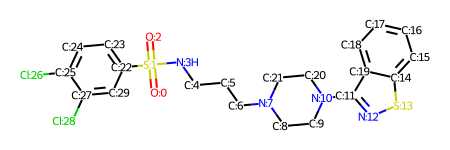

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 1.0, 'N': 0.0, 

第9个原子符号修改为F不符合规范，生成下一个元素……
i: 2 top_idx: 28 rank: 1
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
没有满足条件的分子生成。
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.999, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
--------------------------------------------------

原子位16生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 2 rank: 0
原子位2生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 3 rank: 0
原子位0生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 4 rank: 0
原子位28生成O元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 5 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 6 rank: 0
原子位14生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 7 rank: 0
原子位15生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 8 rank: 0
原子位23生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 9 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 10 rank: 0
第13个原子符号修改为Cl不符合规范，生成下一个元素……
i: 3 top_idx: 10 rank: 1
原子位13生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 11 rank: 0
原子位25生成F元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 12 rank: 0
原子位10生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 13 rank: 0
原子位27生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 14 rank: 0
第19个原子符号修改为F不符合规范，生成下一个元素……
i: 3 top_idx: 14 rank: 1
原子位19生成N元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 15 rank: 0
原子位7生成C元素的置信度小于0.001，寻找下一个原子位……
i: 3 top_idx: 16 rank: 0
原子位29生成F元素的置信度小于0.001，寻找下一个原子位……

原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 2 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 3 rank: 0
原子位14生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 4 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 5 rank: 0
原子位6生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 6 rank: 0
原子位13生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 7 rank: 0
原子位7生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 8 rank: 0
原子位8生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 9 rank: 0
原子位16生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 10 rank: 0
原子位12生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 11 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 12 rank: 0
原子位15生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 13 rank: 0
第9个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 13 rank: 1
原子位9生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 14 rank: 0
原子位10生成F元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 15 rank: 0
原子位1生成N元素的置信度小于0.001，寻找下一个原子位……
i: 4 top_idx: 16 rank: 0
第0个原子符号修改为F不符合规范，生成下一个元素……
i: 4 top_idx: 16 rank: 1
第0个原子符号修改为N不符合规范，生成下一个元素……
i: 4 top_idx: 1

原子位20生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 1 rank: 0
原子位1生成Cl元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 2 rank: 0
原子位4生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 3 rank: 0
原子位5生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 4 rank: 0
原子位19生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 5 rank: 0
原子位2生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 6 rank: 0
原子位3生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 7 rank: 0
原子位24生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 8 rank: 0
原子位18生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 9 rank: 0
原子位6生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 10 rank: 0
原子位0生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 11 rank: 0
原子位25生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 12 rank: 0
原子位17生成N元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 13 rank: 0
原子位21生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 14 rank: 0
原子位8生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 15 rank: 0
原子位22生成F元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 16 rank: 0
原子位11生成C元素的置信度小于0.001，寻找下一个原子位……
i: 5 top_idx: 17 rank: 0
原子位7生成F元素的置信度小于0.001，寻找下一个原子位

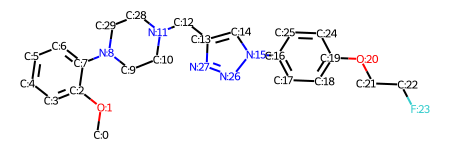

将第23个原子修改为C的分子： CCCOc1ccc(C2CC(CN3CCN(c4ccccc4OC)CC3)NN2)cc1


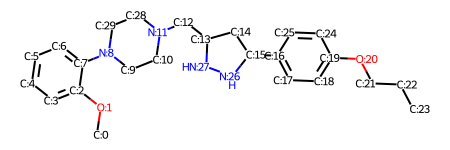

高活性分子： COc1ccccc1N1CCN(Cc2cn(-c3ccc(OCCCF)cc3)nn2)CC1


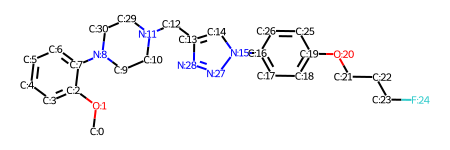

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 1.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.0, 'N': 0.999

atom#7(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.0, 'N': 1.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.001, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.001, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C': 0

In [40]:
stopper.load_checkpoint(model)
stopper_afse.load_checkpoint(amodel)
stopper_generate.load_checkpoint(gmodel)
    
reconstruction_rate, success_validity, unique_rate, novelty_rate, success_smiles, init_smiles, generated_smiles, test_r2, test_MSE, test_predict = eval(model, amodel, gmodel, test_df, topn=1, generate=True, validate=True, print_flag=True)

test_predict = np.array(test_predict)

print("----------")
print('Reconstruction: %.4f'%reconstruction_rate,'\nValidity: %.4f'%success_validity)
print('Unique: %.4f'%unique_rate,'\nNovelty: %.4f'%novelty_rate, 
      '\nAverage: %.4f'%((reconstruction_rate+success_validity+unique_rate+novelty_rate)/4))

In [41]:
import math
import pickle
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import os
import os.path as op
 
#get_sa_score start
_fscores = None
 
def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
    if name == "fpscores":
        name = op.join(os.getcwd(), name)
        # name = op.join(op.dirname(__file__), name)
    data = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict
 
 
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro
 
def calculateScore(m):
    if _fscores is None:
        readFragmentScores()
 
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                            2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf
 
    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1
 
    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    # macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)
 
    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty
 
    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5
 
    sascore = score1 + score2 + score3
 
    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0
 
    return sascore

def SA_score(mols:list):
    ss = []
    readFragmentScores("fpscores")
#     print('smiles\tsa_score')
    for m in mols:
        s = calculateScore(m)
        smiles = Chem.MolToSmiles(m)
        ss.append(s)
#         print(smiles + "\t" + "\t%3f" % s)
    return ss

In [42]:
QED_scores_init = []
logP_scores_init = []
init_mols = []
init_valid_smiles = []
smiles_num = len(init_smiles)
for i in range(smiles_num):
    mol = Chem.MolFromSmiles(init_smiles[i])
    if mol is not None:
        init_mols.append(mol)
        init_valid_smiles.append(Chem.MolToSmiles(mol))
        QED = Chem.QED.default(mol)
        QED_scores_init.append(QED)
        logP = Chem.Crippen.MolLogP(mol)
        logP_scores_init.append(logP)
SA_scores_init = np.array(SA_score(init_mols))
QED_scores_init = np.array(QED_scores_init)
QED_scores_init_ranked = np.sort(QED_scores_init)
logP_scores_init = np.array(logP_scores_init)

QED_scores = []
logP_scores = []
generated_mols = []
generated_valid_smiles = []
smiles_num = len(generated_smiles)
for i in range(smiles_num):
    mol = Chem.MolFromSmiles(generated_smiles[i])
    if mol is not None:
        generated_mols.append(mol)
        generated_valid_smiles.append(Chem.MolToSmiles(mol))
        QED = Chem.QED.default(mol)
        QED_scores.append(QED)
        logP = Chem.Crippen.MolLogP(mol)
        logP_scores.append(logP)
SA_scores = np.array(SA_score(generated_mols))
QED_scores = np.array(QED_scores)
QED_scores_ranked = np.sort(QED_scores)
logP_scores = np.array(logP_scores)
print('QED Rank:', QED_scores_ranked[-5:],
      '\nQED（越大类药性越高）: %.4f'%max(QED_scores), '%.4f'%(sum(QED_scores)/smiles_num),'%.4f'%min(QED_scores),
      '\nSA（越小可合成性越高）: %.4f'%max(SA_scores), '%.4f'%(sum(SA_scores)/smiles_num),'%.4f'%min(SA_scores),
      '\nlogP（越大疏水性越好）: %.4f'%max(logP_scores), '%.4f'%(sum(logP_scores)/smiles_num),'%.4f'%min(logP_scores),
      )

QED Rank: [0.87860455 0.87860455 0.87860455 0.89450245 0.91460755] 
QED（越大类药性越高）: 0.9146 0.6156 0.0310 
SA（越小可合成性越高）: 5.5951 2.9153 1.8592 
logP（越大疏水性越好）: 6.3425 3.5033 1.5279


In [43]:
I_SMILES_Dict = {init_valid_smiles[i]: [QED_scores_init[i], SA_scores_init[i], logP_scores_init[i]] for i in range(len(init_valid_smiles))}
G_SMILES_Dict = {generated_valid_smiles[i]: [QED_scores[i], SA_scores[i], logP_scores[i]] for i in range(len(generated_valid_smiles))}
print(len(init_valid_smiles),len(generated_valid_smiles))
for i, smiles in enumerate(success_smiles):
    index = generated_valid_smiles.index(smiles)
    print('原始测试集分子：',init_valid_smiles[index],
          '\n原始测试集分子活性值：%.4f'%(train_df['value'].values[train_df.cano_smiles.values==init_valid_smiles[index]][0].astype(float)+9),
         '\nQED（越大类药性越高）: %.4f'%I_SMILES_Dict[init_valid_smiles[index]][0],
          '\nSA（越小可合成性越高）: %.4f'%I_SMILES_Dict[init_valid_smiles[index]][1],
          '\nlogP（越大疏水性越好）: %.4f'%I_SMILES_Dict[init_valid_smiles[index]][2],
         '\n\n成功生成的高活性分子：',smiles,
          '\nActivity（越大药效越好）: %.4f'%(test_df['value'].values[test_df.cano_smiles.values==smiles][0].astype(float)+9),
         '\nQED（越大类药性越高）: %.4f'%G_SMILES_Dict[smiles][0],
          '\nSA（越小可合成性越高）: %.4f'%G_SMILES_Dict[smiles][1],
          '\nlogP（越大疏水性越好）: %.4f'%G_SMILES_Dict[smiles][2],
         '\n------------------------------------------------------------------------------------------------------------')

76 75
原始测试集分子： CCCN1CCC(c2coc3ccccc23)CC1 
原始测试集分子活性值：5.7545 
QED（越大类药性越高）: 0.8091 
SA（越小可合成性越高）: 2.1075 
logP（越大疏水性越好）: 4.0222 

成功生成的高活性分子： CCCN1CCC(c2csc3ccccc23)CC1 
Activity（越大药效越好）: 7.1337 
QED（越大类药性越高）: 0.7847 
SA（越小可合成性越高）: 2.0823 
logP（越大疏水性越好）: 4.4907 
------------------------------------------------------------------------------------------------------------
原始测试集分子： CCCN(CCc1ccc(C)cc1)C1CCc2c(O)cccc2C1 
原始测试集分子活性值：6.7696 
QED（越大类药性越高）: 0.8451 
SA（越小可合成性越高）: 2.6875 
logP（越大疏水性越好）: 4.5126 

成功生成的高活性分子： CCCN(CCc1ccc(N)cc1)C1CCc2c(O)cccc2C1 
Activity（越大药效越好）: 8.1675 
QED（越大类药性越高）: 0.7950 
SA（越小可合成性越高）: 2.7957 
logP（越大疏水性越好）: 3.7864 
------------------------------------------------------------------------------------------------------------
原始测试集分子： Cl.O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccccc2o1 
原始测试集分子活性值：5.2411 
QED（越大类药性越高）: 0.4522 
SA（越小可合成性越高）: 2.2858 
logP（越大疏水性越好）: 5.4936 

成功生成的高活性分子： Cl.O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccccc2s1 
Activity（越大药效越好）: 6.7696 
QED（

In [ ]:
# print('target_file:',train_filename)
# print('inactive_file:',test_filename)
# np.savez('./result/G_AFSE_'+file1, epoch_list, train_f_list, train_d_list, 
#          train_predict_list, train_y_list, val_f_list, val_d_list, val_predict_list, val_y_list, test_f_list, 
#          test_d_list, test_predict_list, test_y_list)
# sim_space = np.load('./result/G_AFSE_'+file1+".npz")
# print(sim_space['arr_10'].shape)

In [ ]:
# 重构原子类型
# activated_features=activated_features